In [1]:
%reset -f

In [2]:
#imports
import pandas as pd
import numpy as np
import nltk
import re
import os
from tqdm import tqdm, tqdm_pandas
#tqdm_pandas(tqdm())
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt 
import matplotlib as mpl

def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return
setup_mpl()

# Text preprocessing

The preprocessing of the text is done through the Porter stemmer, which stems all words, i.e., converts words to their stem by removing common endings from words. Afterwards, any stopwords - the most common, non-meaningful words such as "a", "the", etc. - are removed, while any words containing non alphabetical characters are removed and urls are converted to the common string, "URL". 

In [3]:
# Preprocessing function

porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

# Keep numbers / Remove numbers / Substitute numbers with token


def preprocess(text):
    #Common english stop words
    stop_words = set(stopwords.words('english'))
    # Substituting urls with 
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(r'http\S+', '#URL#', str(text)) # Maybe change to single-character-symbol -> shingles
    #Tokenize using nltk
    word_tokens = word_tokenize(text.lower())
    #removing none letter characters and stop words
    filtered_sentence = [w for w in word_tokens if w not in stop_words and w.isalpha()]
    #Conduct stemming
    processed_text = [porter.stem(t) for t in filtered_sentence]
    return processed_text

Then the clean CSV.-files are created, ready to be used for data analysis and as input to machine learning models. 

### SMS spam: 

In [4]:
PATH = "../data/regular/spam.csv"
SMS = pd.read_csv(PATH)[['v1','v2']]
SMS = SMS.rename(columns={'v1': 'label', 'v2': 'text'})

label = SMS['label'].values
text = SMS['text'].values

In [5]:
SMS['tokens'] = [preprocess(x) for x in tqdm(SMS['text'])]
SMS['str_tokens'] = [' '.join(x) for x in tqdm(SMS['tokens'])]
# Removing rows of emtpty tokens
SMS = SMS[SMS['tokens'].astype(bool)]
binary_dict = {'ham': 0, 'spam': 1}
SMS['binary'] = [binary_dict[x] for x in tqdm(SMS['label'])]
SMS.to_csv('../data/clean/clean_spam.csv', index=False)


100%|██████████| 5551/5551 [00:00<00:00, 1916735.12it/s]


### Email spam

In [6]:
PATH = "../data/regular/completeSpamAssassin.csv"
EMAIL = pd.read_csv(PATH, index_col = 'Unnamed: 0')

EMAIL.rename(columns = {'Label':'label', 'Body':'text'}, inplace = True)

EMAIL['label'] = EMAIL['label'].replace(0, 'ham')
EMAIL['label'] = EMAIL['label'].replace(1, 'spam')

# Removing 'empty' rows
EMAIL.text = np.where(EMAIL.text.isin(['empty']), np.nan, EMAIL.text)
EMAIL = EMAIL.dropna().reset_index().drop(columns=['index'])

In [7]:
EMAIL['tokens'] = [preprocess(x) for x in tqdm(EMAIL['text'])]
EMAIL['str_tokens'] = [' '.join(x) for x in tqdm(EMAIL['tokens'])]
EMAIL = EMAIL[EMAIL['tokens'].astype(bool)]
binary_dict = {'ham': 0, 'spam': 1}
EMAIL['binary'] = [binary_dict[x] for x in tqdm(EMAIL['label'])]
EMAIL.to_csv('../data/clean/clean_completeSpamAssassin.csv', index=False)

100%|██████████| 5507/5507 [00:00<00:00, 1938567.53it/s]


In [8]:
EMAIL

,text,label,tokens,str_tokens,binary
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,spam,"[save, life, insur, spend, life, quot, save, e...",save life insur spend life quot save ensur fam...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,"[fight, risk, cancer, url, slim, guarante, los...",fight risk cancer url slim guarante lose lb da...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam,"[fight, risk, cancer, url, slim, guarante, los...",fight risk cancer url slim guarante lose lb da...,1
3,##############################################...,spam,"[adult, club, offer, free, membership, instant...",adult club offer free membership instant acces...,1
4,I thought you might like these:\n1) Slim Down ...,spam,"[thought, might, like, slim, guarante, lose, l...",thought might like slim guarante lose lb day u...,1
...,...,...,...,...,...
5507,----------------------------------------------...,ham,"[isilo, tm, palm, os, pocket, pc, window, ente...",isilo tm palm os pocket pc window enter isilo ...,0
5508,"EFFector Vol. 15, No. 35 November ...",ham,"[effector, vol, novemb, ren, public, electron,...",effector vol novemb ren public electron fronti...,0
5509,\nWe have extended our Free seat sale until Th...,ham,"[extend, free, seat, sale, thursday, novemb, d...",extend free seat sale thursday novemb detail s...,0
5510,___ ___ ...,ham,"[insignific, matter, heavili, overemphasis, hu...",insignific matter heavili overemphasis hugh mt...,0


Download of clean [CSV-files](https://we.tl/t-1A7Gx6rxG7)

# Data Analysis

In [9]:
%reset -f

#imports
import pandas as pd
import numpy as np
import nltk
import re
import os
from tqdm import tqdm, tqdm_pandas
#tqdm_pandas(tqdm())
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Sources
https://www.researchgate.net/figure/Average-daily-number-of-base-stations-visited-by-spammers-red-legitimate-customers_fig1_262330820
https://towardsdatascience.com/spam-detection-in-sms-messages-3322e03300f5


# Data Analysis

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [11]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return
setup_mpl()

The following analysis will investigate the nature of the spam/ham dataset. More specifically, we will look into how long the typical SMS/email is for each group respectively. Subsequently, we will investigate the amount of spelling mistakes present in each group.

In [12]:
from ast import literal_eval

datasets = ['clean_spam.csv', 'clean_completeSpamAssassin.csv'] #, 'clean_Job_postings.csv', 'clean_NEWS.csv']

dfs = {'clean_spam.csv': {'data': [], 'spam': [], 'ham': [], 'type': 'SMS'},
       'clean_completeSpamAssassin.csv': {'data': [], 'spam': [], 'ham': [], 'type': 'E-mail'},
      }
       #'clean_Job_postings.csv': {'data': [], 'fraudulent': [], 'genuine': [], 'type': 'Job postings'},
       #'clean_NEWS.csv': {'data': [], 'fake': [], 'real': [], 'type': 'News'}}

for dataset in datasets:
    
    # read data
    df = pd.read_csv('../data/clean/' + dataset, encoding= "ISO-8859-1")

    df.tokens = df.tokens.apply(literal_eval)
    df['len'] = df.tokens.str.len()
    
    # Saving data, and the classes into dictionary
    dfs[dataset]['data'] = df
    dfs[dataset][list(dfs[dataset].keys())[1]] = df[df.label==list(dfs[dataset].keys())[1]]
    dfs[dataset][list(dfs[dataset].keys())[2]] = df[df.label==list(dfs[dataset].keys())[2]]

First let us investigate the proportion of ham and spam in the datasets:

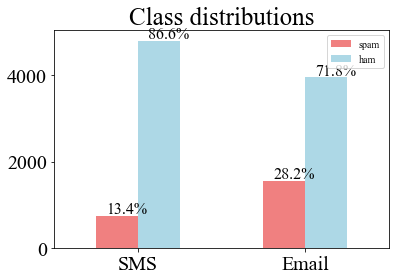

In [13]:
total = []
spam_counts = []
ham_counts = []
for i in range(2):
    total.append(dfs[datasets[i]]['data'].label.value_counts()[0] + dfs[datasets[i]]['data'].label.value_counts()[1])
    spam_counts.append(dfs[datasets[i]]['data'].label.value_counts()[1])
    ham_counts.append(dfs[datasets[i]]['data'].label.value_counts()[0])    
    
from matplotlib.pyplot import figure

# figure(figsize=(20, 10), dpi=100)
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.dpi"] = 100


index = ['SMS', 'Email']
df = pd.DataFrame({'spam': spam_counts, 'ham': ham_counts}, index=index)
ax = df.plot.bar(rot=0, color=['lightcoral', 'lightblue'])
       
for i, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * p.get_height()/total[i%2])
    x = p.get_x() + p.get_width() / 4
    y = p.get_y() + p.get_height() + 60
    ax.annotate(percentage, (x, y), fontsize = 16)  
    ax.tick_params(axis='x', which='both', labelsize=20)
    ax.tick_params(axis='y', which='both', labelsize=20)  
    
plt.title('Class distributions', size = 25)
plt.show()


Getting actual counts of classes

In [14]:
for dataset in datasets:
    print('Dataset:', dataset)
    print(dfs[dataset]['data'].label.value_counts(), "\n")

Dataset: clean_spam.csv
ham     4805
spam     746
Name: label, dtype: int64 

Dataset: clean_completeSpamAssassin.csv
ham     3952
spam    1555
Name: label, dtype: int64 



In [15]:
print("Total observations SMS", 4825 + 747) #5572
print("Total observations Email", 3952 + 1560) # 5512


Total observations SMS 5572
Total observations Email 5512


Notably, the dataset illustrated a significant class imbalance, which would probably have to be taken into account when training models for classification.

The following will analyse the length distribution of spam and ham mails:

Checking for log normality in the text length through Q-Q plots. 

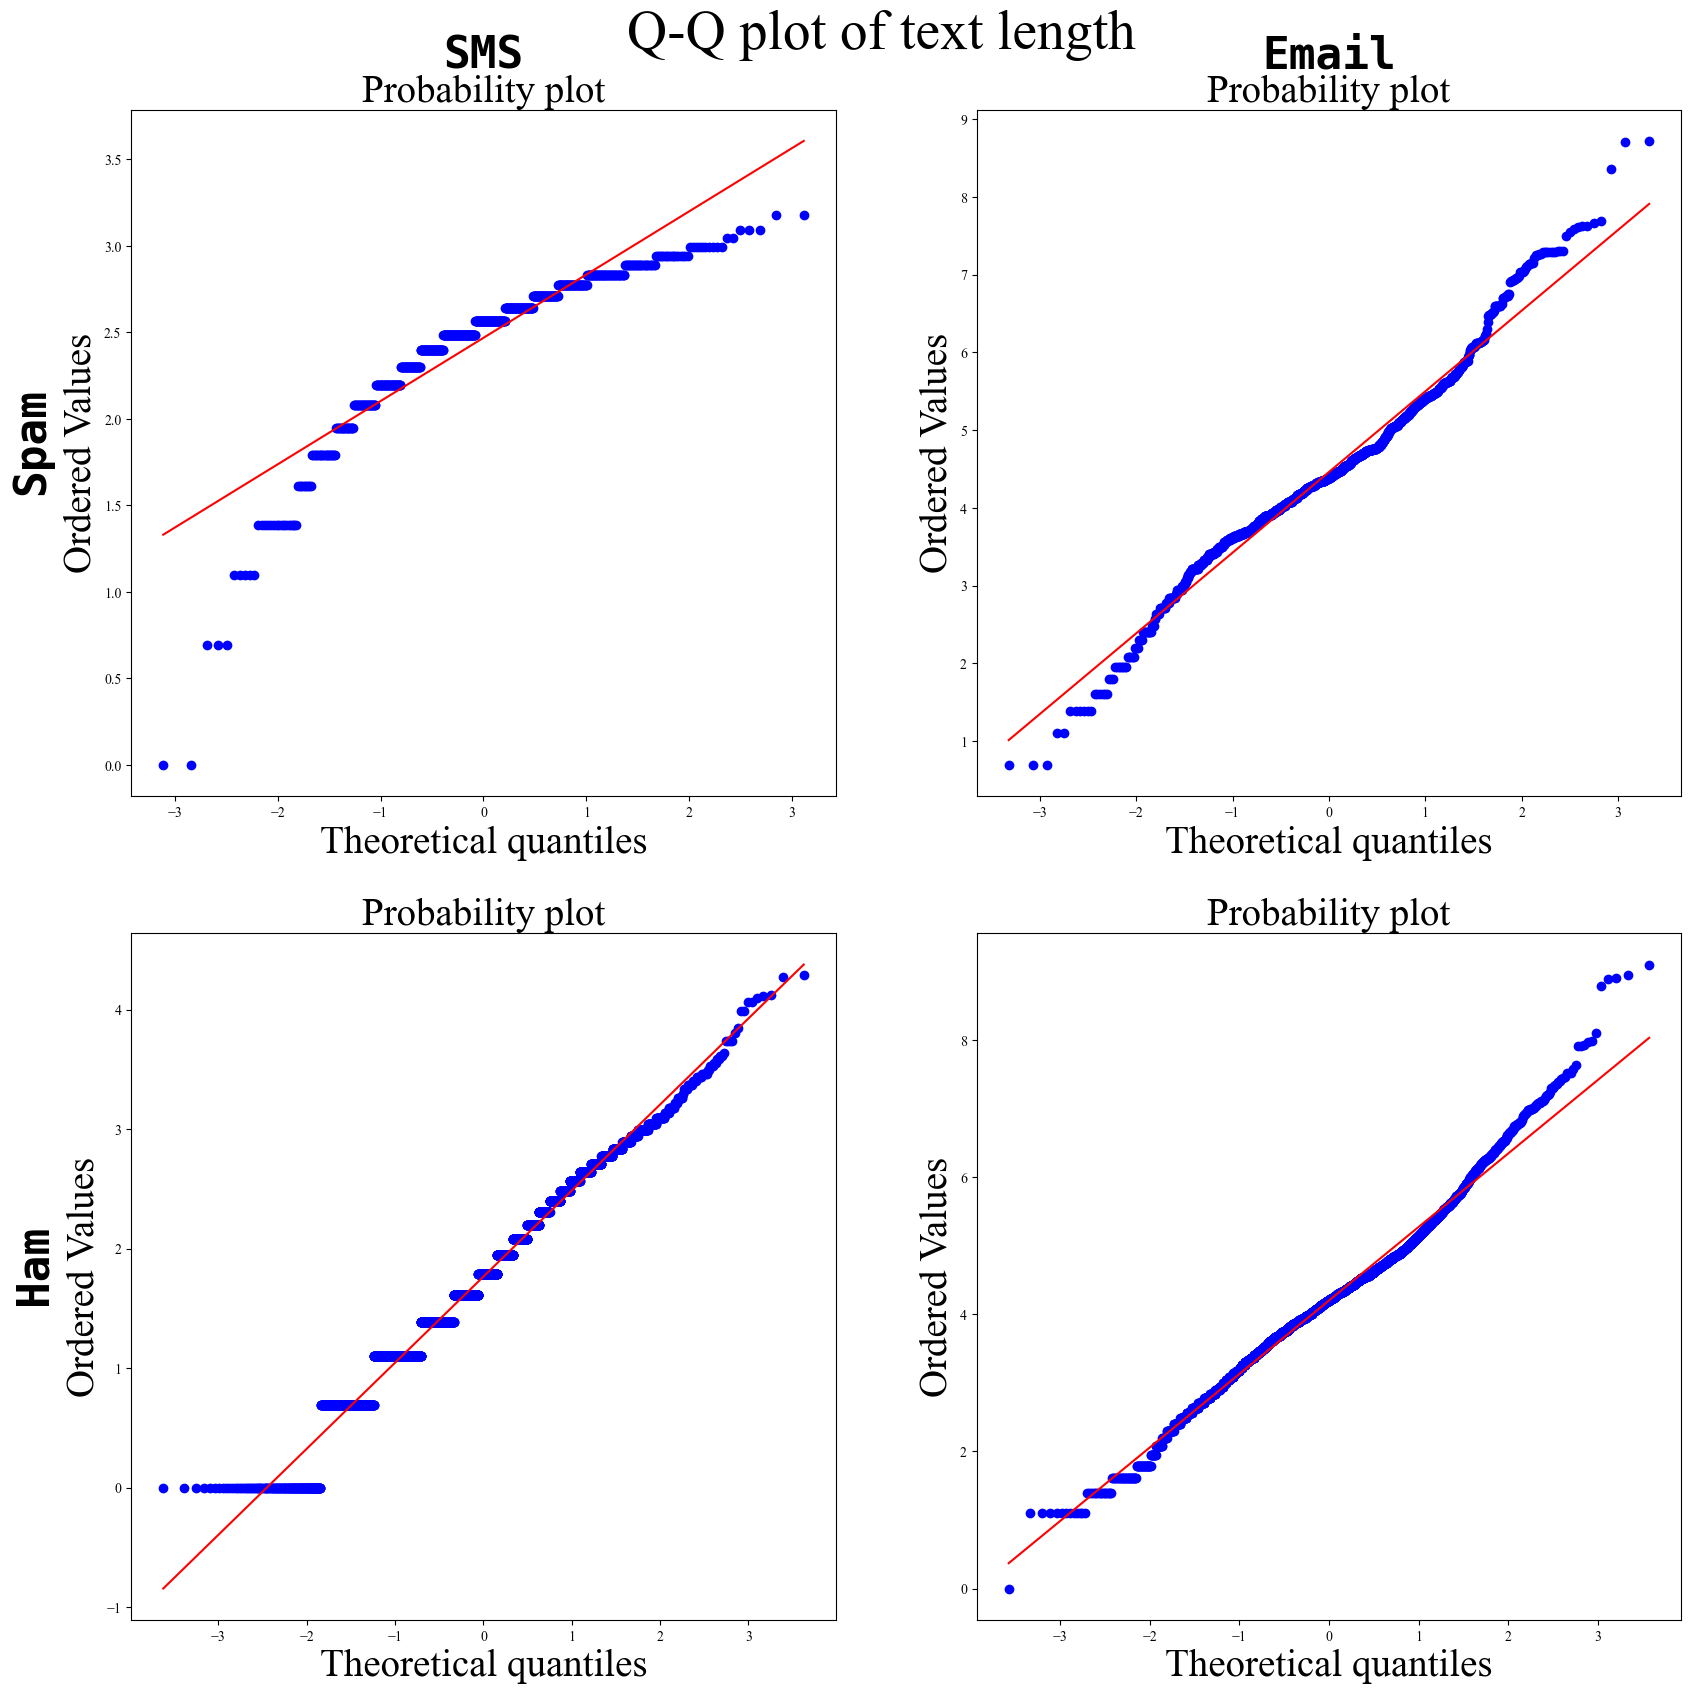

In [16]:
import pylab
import scipy.stats


def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1.05),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(-0.1, 0.55),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 20), dpi=100)

datasets = ['clean_spam.csv', 'clean_completeSpamAssassin.csv']*2
label = ['spam', 'spam', 'ham', 'ham']

col_headers = ['SMS', 'Email']
row_headers = ['Spam', 'Ham']


for i, ax in enumerate(axs.flat):
    measurements = np.log(list(dfs[datasets[i]][label[i]].len.values))
    scipy.stats.probplot(measurements, dist="norm", plot=ax)
    ax.set_title("Probability plot", fontsize = 28)
    ax.set_xlabel("Theoretical quantiles", fontsize=28)
    ax.set_ylabel("Ordered Values", fontsize=28)


font_kwargs = dict(fontfamily="monospace", fontweight="bold", size=32)
add_headers(fig, col_headers=col_headers, row_headers=row_headers, **font_kwargs)

fig.suptitle('Q-Q plot of text length', size = 40, y=0.93)
plt.show()

Since the observations in the Email dataset follow the red line quite nicely, the distribution is said to follow a log normal distribution. Thus the email dataset will be plotted in log-scale in the following plots.

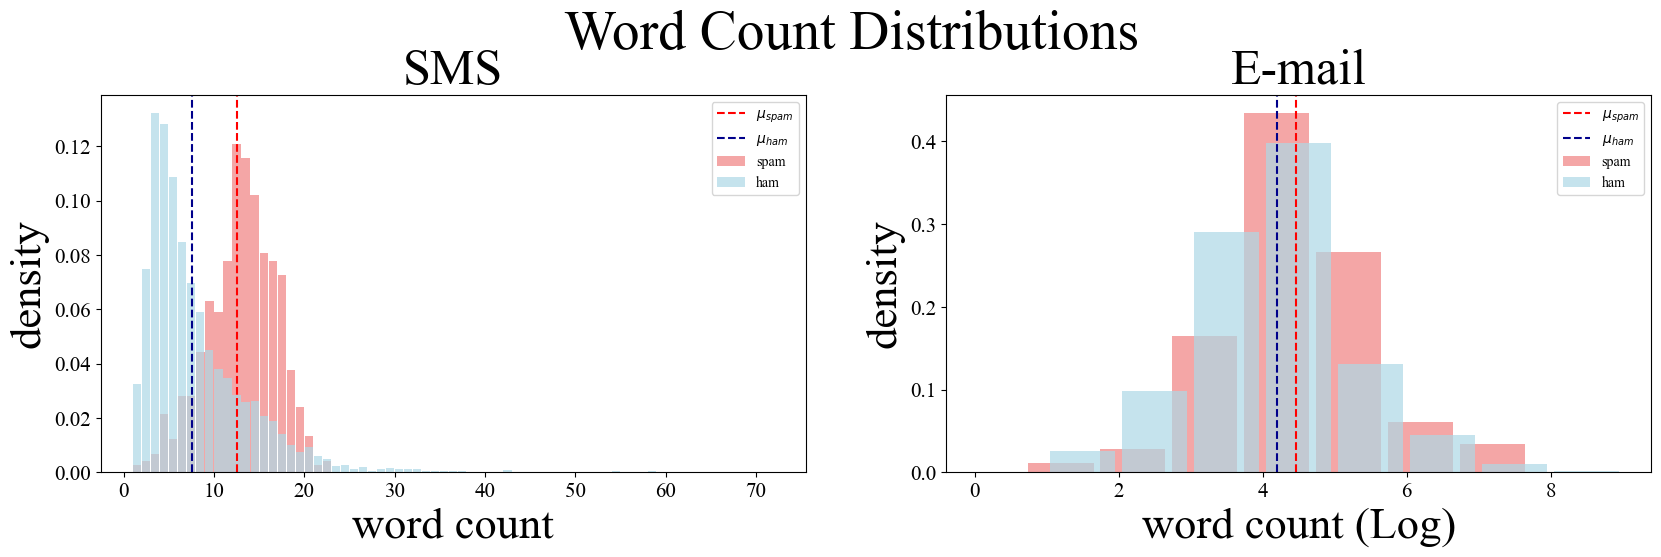

In [17]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5), dpi=100)
fig.subplots_adjust(hspace=0.3)

spam_lens = []
ham_lens = []


for i, ax in enumerate(axs.flat):

    # Accessing correct dataset, and getting word count 
    
    spam_label = list(dfs[datasets[i]].keys())[1]
    ham_label = list(dfs[datasets[i]].keys())[2]
    
    
    if i == 1:
        spam_len = np.log(list(dfs[datasets[i]][spam_label].len.values))
        ham_len = np.log(list(dfs[datasets[i]][ham_label].len.values))
    else:
        spam_len = list(dfs[datasets[i]][spam_label].len.values)
        ham_len = list(dfs[datasets[i]][ham_label].len.values)
        
    spam_lens.append(spam_len)
    ham_lens.append(ham_len)

    bins = np.arange(min(spam_len), max(spam_len), 1)
    hist, edges = np.histogram(spam_len, bins=bins, density=True)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1]-bins[0]

    ax.bar(x, hist, width=width*0.91, color='lightcoral', label=spam_label, alpha=0.7)
    ax.set_ylabel("counts")
    ax.set_xlabel("k")
    ax.set_title("")
    
    ax.axvline(np.mean(spam_len), c='red', label='$\mu_{'+spam_label+'}$', linestyle='dashed')
    ax.axvline(np.mean(ham_len), c='darkblue', label='$\mu_{'+ham_label+'}$', linestyle='dashed')

    bins = np.arange(min(ham_len), max(ham_len), 1)
    hist, edges = np.histogram(ham_len, bins=bins, density=True)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1]-bins[0]
    ax.bar(x, hist, width=width*0.90, color='lightblue', label=ham_label, alpha=0.7)
    ax.tick_params(axis='x', which='both', labelsize=15)
    ax.tick_params(axis='y', which='both', labelsize=15)    

    ax.legend()
    ax.set_ylabel("density", fontsize = 32)
    
    if str(dfs[datasets[i]]['type']) == 'E-mail':
        ax.set_xlabel("word count (Log)", fontsize = 32)
    
    else: 
        ax.set_xlabel("word count", fontsize = 32)
    
    ax.set_title(str(dfs[datasets[i]]['type']), fontsize = 36) #TODO: maybe change to number of words
    
  

plt.suptitle("Word Count Distributions", fontsize = 40, y=1.05)
plt.show()

By visually inspecting the above figure, it appears that spam SMSes tend to have longer content than ham SMSes.
Visually, it is difficult to tell with the other datasets, the following will print the mean and standard deviations useed to create the plots:

In [18]:
for i, dataset in enumerate(datasets[:2]):
    
    print('Dataset:', dataset)
    print()
    print(f'Mean of spam: {np.mean(spam_lens[i])}')
    print(f'Standard deviation of spam: {np.std(spam_lens[i])}')
    print()
    print(f'Mean of ham: {np.mean(ham_lens[i])}')
    print(f'Standard deviation of ham: {np.std(ham_lens[i])}')
    print()
    print()

Dataset: clean_spam.csv

Mean of spam: 12.57372654155496
Standard deviation of spam: 3.8609277108605977

Mean of ham: 7.56108220603538
Standard deviation of ham: 6.004461095151682


Dataset: clean_completeSpamAssassin.csv

Mean of spam: 4.460125620197719
Standard deviation of spam: 1.0482585579346877

Mean of ham: 4.199805870951014
Standard deviation of ham: 1.0770224601413823




Clearly SMSes are of much smaller word count than Emails, not surprisingly, as SMSes tend to be less formal than the written text contained in the other datasets.

Interestingly, the word count of emails have a much higher standard deviation than SMS messages.

The mean and standard deviations within the datasets, do not seem to depend much on whether the text contains spam or ham.

## Spelling mistakes

Furthermore, the following will investigate the proportion of spelling mistakes in each group respectively.

In [19]:
from spellchecker import SpellChecker
import re
import nltk
from tqdm import tqdm

tqdm.pandas()
spell = SpellChecker()

def find_misspelled(row, spell):

    text = row.text.lower()
    words = nltk.tokenize.word_tokenize(text)

    misspelled = [word for word in spell.unknown(words) if str(word) not in ['nan']]
    return misspelled

Finding all misspelled words, and the ratio of which words in a sentence are misspelled. 

In [20]:
spell = SpellChecker()

for dataset in datasets[:2]:
    dfs[dataset]['data']['misspelled'] = dfs[dataset]['data'].progress_apply(lambda row: find_misspelled(row, spell), axis=1)
    dfs[dataset]['data']['misspelled_size'] = dfs[dataset]['data']['misspelled'].apply(lambda x: len(x))

    # Ratio of misspelled words
    dfs[dataset]['data']['misspell_ratio'] = dfs[dataset]['data']['misspelled_size'] / dfs[dataset]['data']['len']
    
    # Saving dataframe per class again
    dfs[dataset][list(dfs[dataset].keys())[1]] = dfs[dataset]['data'][dfs[dataset]['data']['label'] == list(dfs[dataset].keys())[1]]
    dfs[dataset][list(dfs[dataset].keys())[2]] = dfs[dataset]['data'][dfs[dataset]['data']['label'] == list(dfs[dataset].keys())[2]]    

100%|██████████| 5507/5507 [00:16<00:00, 333.01it/s]


In [21]:
# Ratio in total data:
for dataset in datasets[:2]:
    
    print("Total ratio of spam misspellings in", dataset+":", np.sum(dfs[dataset]['spam']['misspelled_size']) / np.sum(dfs[dataset]['spam']['len']))
    print("Total ratio of ham misspellings in", dataset+":", np.sum(dfs[dataset]['ham']['misspelled_size']) / np.sum(dfs[dataset]['ham']['len']))    

Total ratio of spam misspellings in clean_spam.csv: 0.3549040511727079
Total ratio of ham misspellings in clean_spam.csv: 0.24040075968181443
Total ratio of spam misspellings in clean_completeSpamAssassin.csv: 0.1577784753467499
Total ratio of ham misspellings in clean_completeSpamAssassin.csv: 0.21005309046714657


Once again doing Q-Q plots, this time for the misspelling count within data sets.

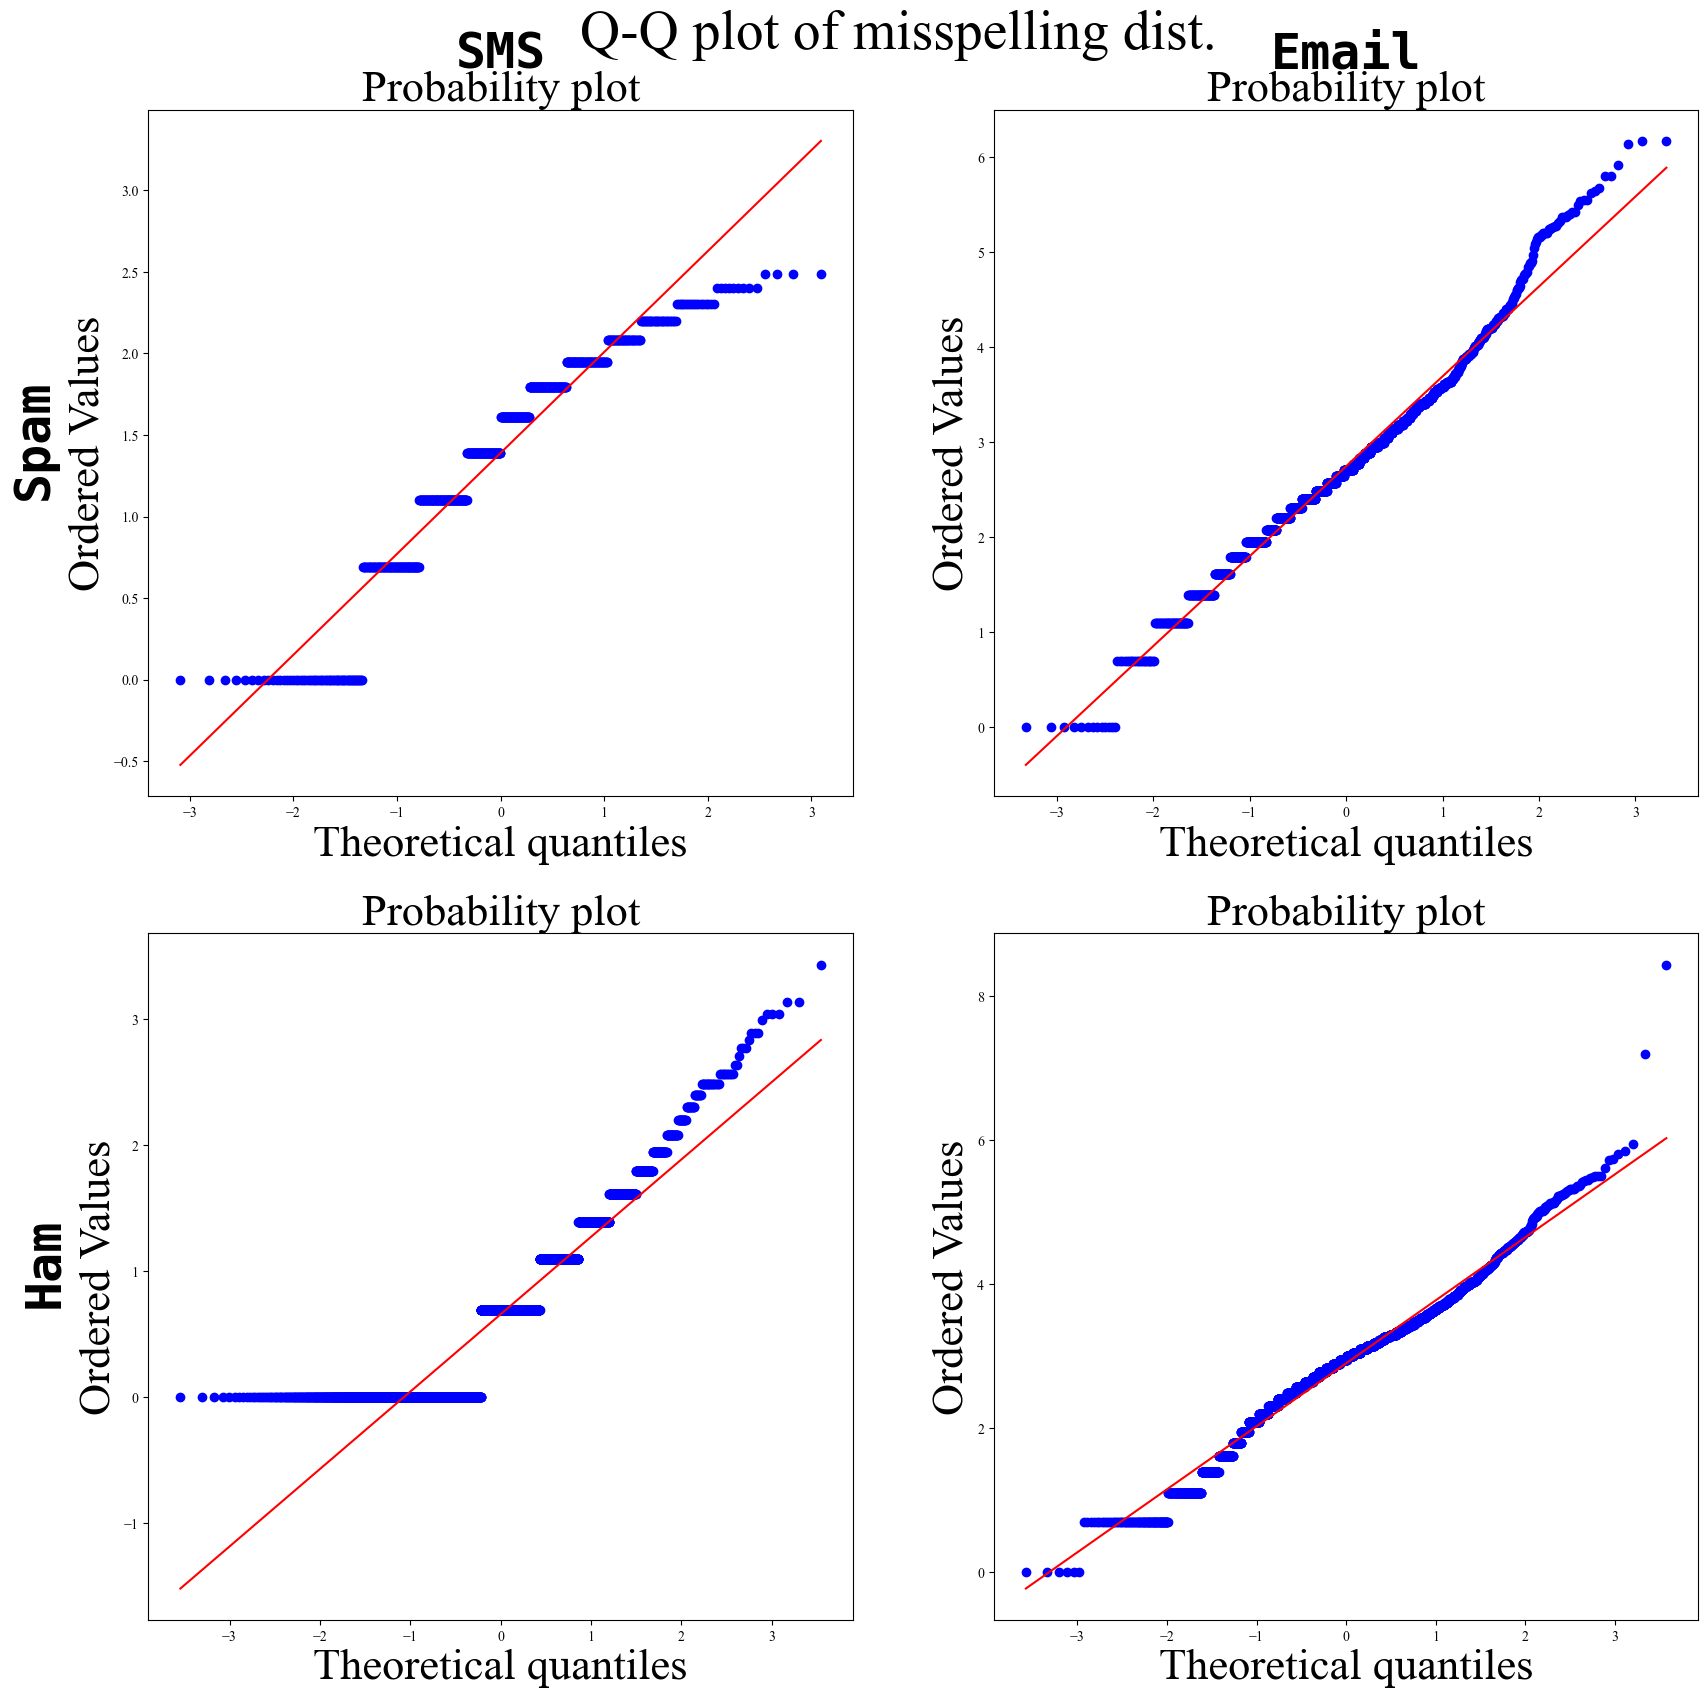

In [22]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(20, 20), dpi=100)

datasets = ['clean_spam.csv', 'clean_completeSpamAssassin.csv']*2
label = ['spam', 'spam', 'ham', 'ham']

col_headers = ['SMS', 'Email']
row_headers = ['Spam', 'Ham']


for i, ax in enumerate(axs.flat):
    lst = np.array(dfs[datasets[i]][label[i]].misspelled_size.values)
    measurements = np.log(lst[lst != 0])
    scipy.stats.probplot(measurements, dist="norm", plot=ax)
    ax.set_title("Probability plot", fontsize = 32)
    ax.set_xlabel("Theoretical quantiles", fontsize=32)
    ax.set_ylabel("Ordered Values", fontsize=32)


font_kwargs = dict(fontfamily="monospace", fontweight="bold", size = 36)
add_headers(fig, col_headers=col_headers, row_headers=row_headers, **font_kwargs)

fig.suptitle('Q-Q plot of misspelling dist.', size = 40, y=0.93)
plt.show()

As is seen, the email dataset once again follows a log normal distribution, thus when plotting the log-scale is used for easier visualization. 

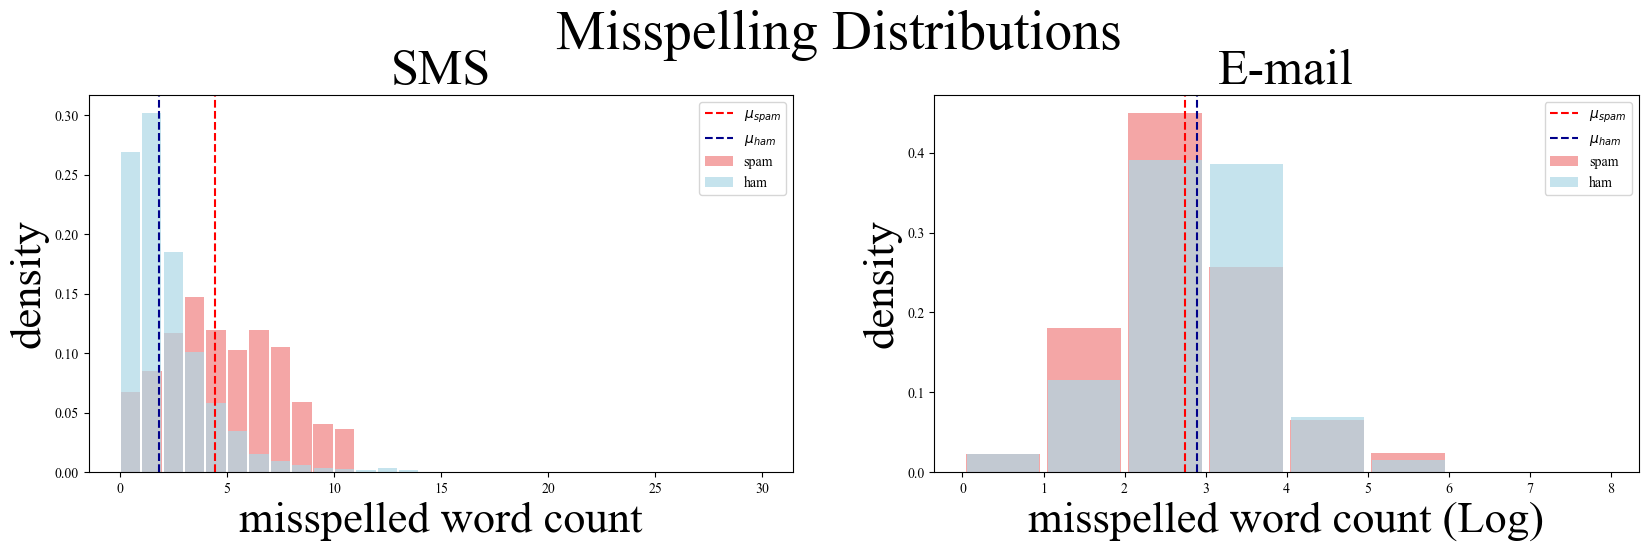

In [23]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20,5), dpi=100)
fig.subplots_adjust(hspace=0.3)

spam_lens = []
ham_lens = []

for i, ax in enumerate(axs.flat):

    spam_label = list(dfs[datasets[i]].keys())[1]
    ham_label = list(dfs[datasets[i]].keys())[2]

    if i == 1:
        lst = np.array(dfs[datasets[i]][spam_label].misspelled_size.values)
        spam_len = np.log(lst[lst != 0])
        lst = np.array(dfs[datasets[i]][ham_label].misspelled_size.values)
        ham_len = np.log(lst[lst != 0])
    else:
        spam_len = list(dfs[datasets[i]][spam_label].misspelled_size.values)
        ham_len = list(dfs[datasets[i]][ham_label].misspelled_size.values)
    
    spam_lens.append(spam_len)
    ham_lens.append(ham_len)

    bins = np.arange(min(spam_len), max(spam_len), 1)
    hist, edges = np.histogram(spam_len, bins=bins, density=True)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1]-bins[0]

    # fig, ax = plt.subplots(1, figsize=(10,5), dpi=100)
    ax.bar(x, hist, width=width*0.91, color='lightcoral', label=spam_label, alpha=0.7)
    ax.set_ylabel("counts")
    ax.set_xlabel("k")
    ax.set_title("")

    ax.axvline(np.mean(spam_len), c='red', label='$\mu_{'+spam_label+'}$', linestyle='dashed')
    ax.axvline(np.mean(ham_len), c='darkblue', label='$\mu_{'+ham_label+'}$', linestyle='dashed')

    bins = np.arange(min(ham_len), max(ham_len), 1)
    hist, edges = np.histogram(ham_len, bins=bins, density=True)
    x = (edges[1:] + edges[:-1])/2
    width = bins[1]-bins[0]
    ax.bar(x, hist, width=width*0.90, color='lightblue', label=ham_label, alpha=0.7)

    ax.legend()
    ax.set_ylabel("density")
    ax.set_xlabel("Misspelled words")
    ax.set_title("Misspelling Distribution")
    
    ax.set_ylabel("density", fontsize = 32)
    if str(dfs[datasets[i]]['type']) == 'E-mail':
        ax.set_xlabel("misspelled word count (Log)", fontsize = 32)
        
    else: 
        ax.set_xlabel("misspelled word count", fontsize = 32)
        
    ax.set_title(str(dfs[datasets[i]]['type']), fontsize = 36) #TODO: maybe change to number of words

plt.suptitle("Misspelling Distributions", fontsize = 40, y=1.05)    

plt.show()



Descriptive statistics: 

In [24]:
for i, dataset in enumerate(datasets[:2]):
    
    print('Dataset:', dataset)
    print()
    print(f'Mean of spam: {np.mean(spam_lens[i])}')
    print(f'Standard deviation of spam: {np.std(spam_lens[i])}')
    print()
    print(f'Mean of ham: {np.mean(ham_lens[i])}')
    print(f'Standard deviation of ham: {np.std(ham_lens[i])}')
    print()
    print()

Dataset: clean_spam.csv

Mean of spam: 4.462466487935657
Standard deviation of spam: 2.7392120992139612

Mean of ham: 1.8176899063475547
Standard deviation of ham: 2.2240898643853617


Dataset: clean_completeSpamAssassin.csv

Mean of spam: 2.7455058294933132
Standard deviation of spam: 0.9522189031917235

Mean of ham: 2.8965008912677277
Standard deviation of ham: 0.8832954856919721




The following section will analyse the most commonly misspelled words within each category, in order to create word clouds. 

In [25]:
spam_freq_dist = {}
ham_freq_dist = {}

for ds in datasets[:2]:
    spam_label = list(dfs[ds].keys())[1]
    ham_label = list(dfs[ds].keys())[2]
    spam_freq_dist[ds] = nltk.FreqDist(dfs[ds][spam_label].misspelled.explode().values)
    ham_freq_dist[ds] = nltk.FreqDist(dfs[ds][ham_label].misspelled.explode().values)


In [26]:
for (key, value) in spam_freq_dist.items():
    spam_freq_dist[key] = {k: v for k, v in sorted(value.items(), key=lambda item: item[1], reverse=True)  if not type(k) == float}

for (key, value) in ham_freq_dist.items():
    ham_freq_dist[key] = {k: v for k, v in sorted(value.items(), key=lambda item: item[1], reverse=True)  if not type(k) == float}



In [27]:
mpl.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

Now plotting the most frequently misspelled words.

In [28]:
list(dfs[datasets[i]].keys())[1]

'spam'

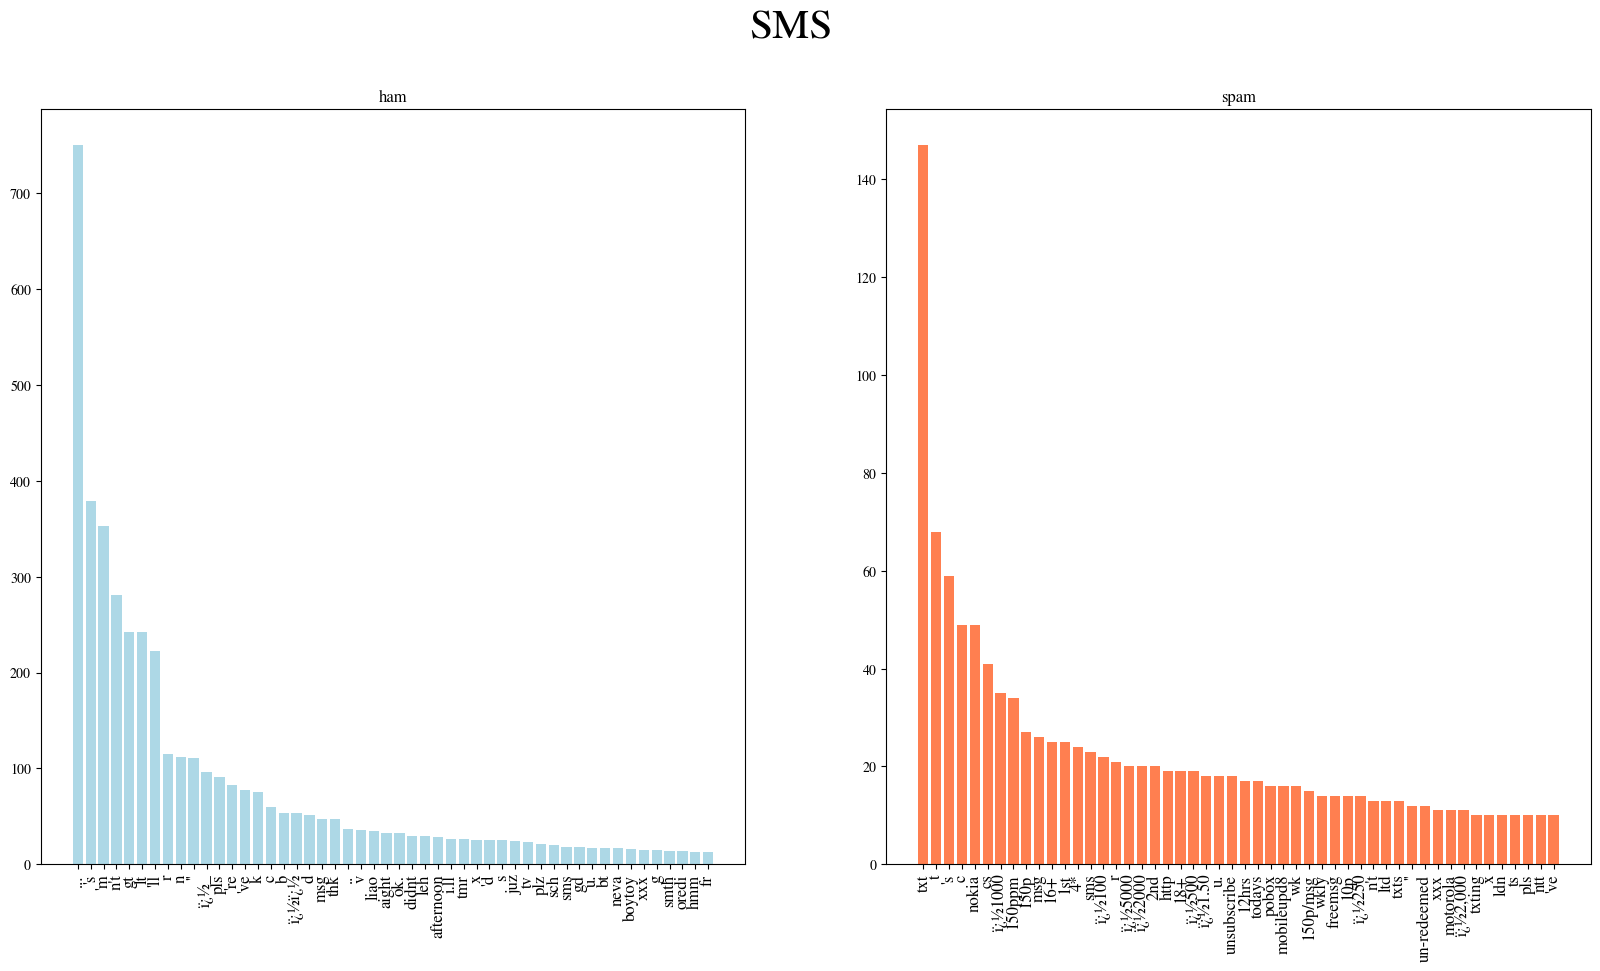

<ipython-input-29-80e1c21464f2>:19: UserWarning: Glyph 130 (\x82) missing from current font.
  plt.savefig('wordfreq_'+dfs[ds]['type']+'.png')
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


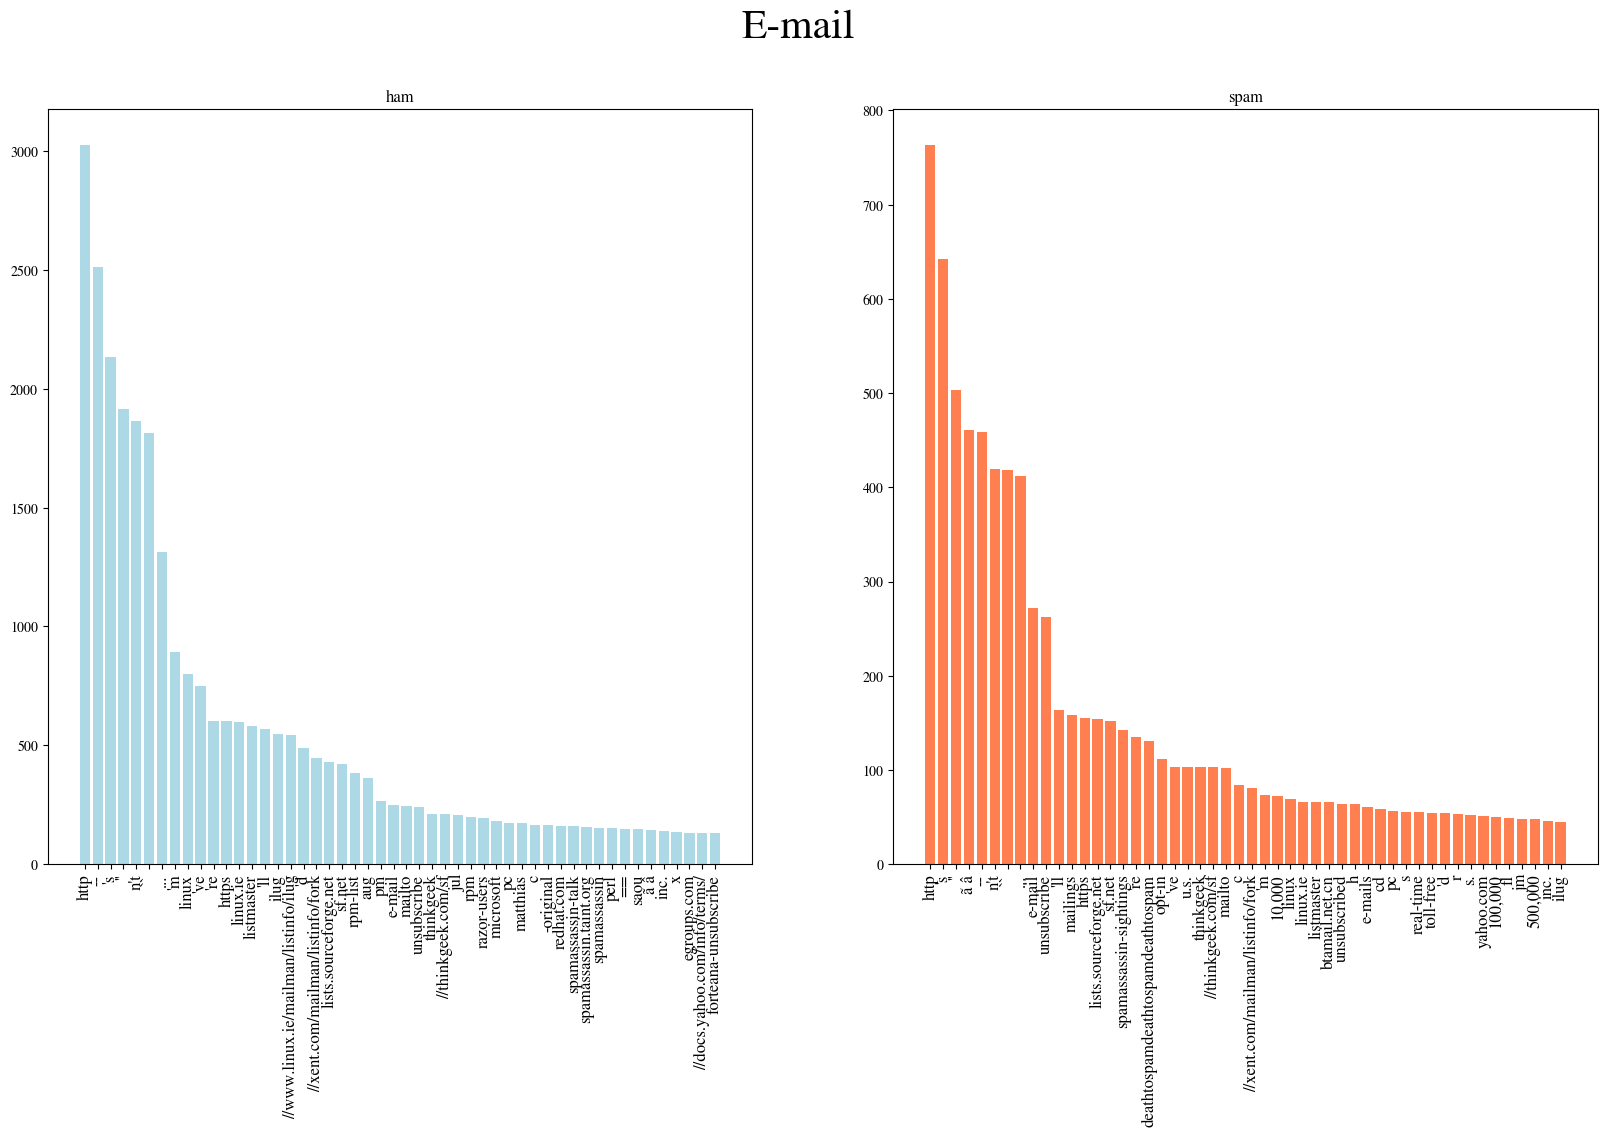

In [29]:
k=50

for ds in datasets[:2]:    

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20,10),dpi=100)
    
    spam_ham = [ham_freq_dist[ds], spam_freq_dist[ds]]
    labels = [list(dfs[datasets[i]].keys())[2], list(dfs[datasets[i]].keys())[1]]
    colors = ['lightblue', 'coral']

    for i, ax in enumerate(axs.flat):

        ax.bar(list(spam_ham[i].keys())[:k], list(spam_ham[i].values())[:k], color=colors[i])
        ax.title.set_text(labels[i])
        ax.tick_params(axis="x", labelsize=12, rotation=90)
        
    fig.suptitle(dfs[ds]['type'], fontsize=30)
    
    plt.savefig('wordfreq_'+dfs[ds]['type']+'.png')
    plt.show()

And finally the word clouds. Each word-cloud is colored according to the spam/ham category. 

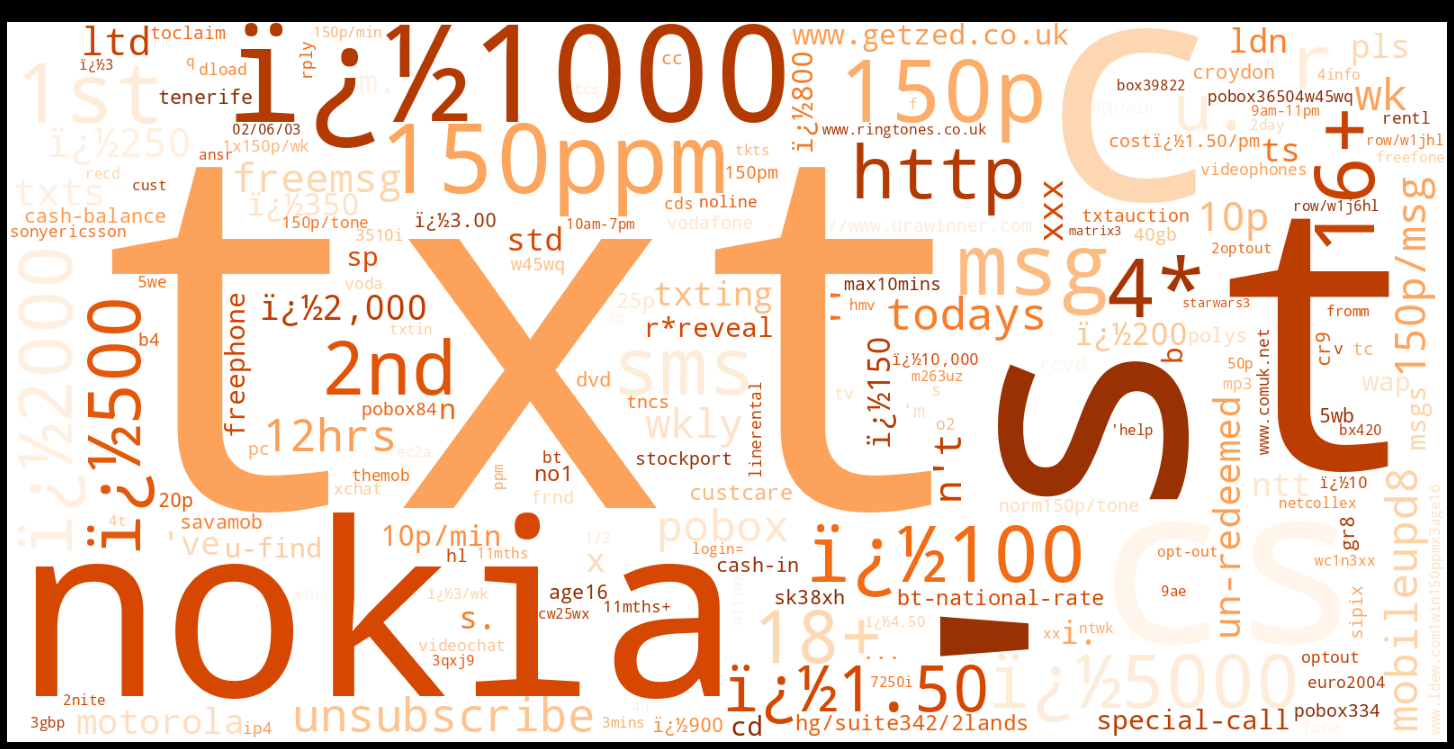

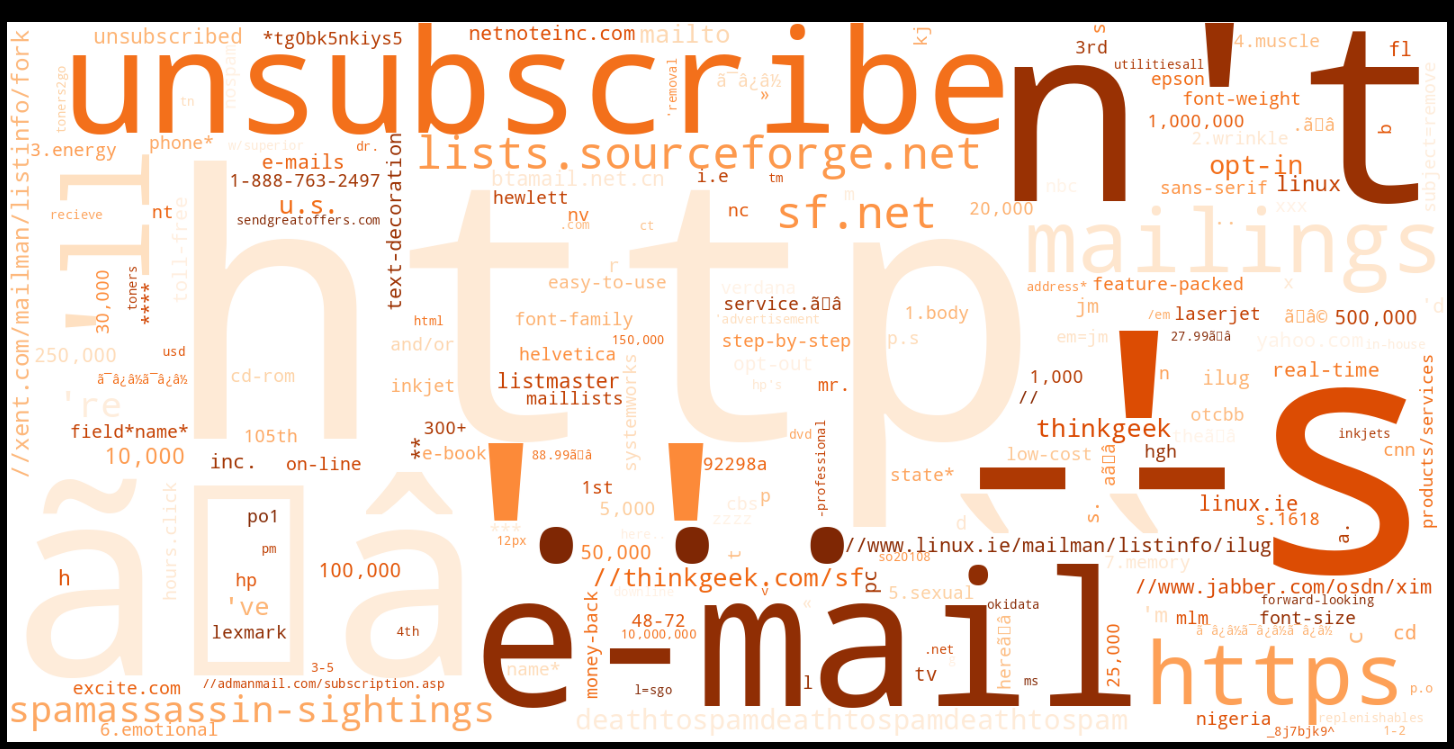

In [30]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", width=1600, height=800, colormap="Oranges")

for ds in datasets[:2]:
    spam_cloud = wordcloud.generate_from_frequencies(frequencies=spam_freq_dist[ds])

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(spam_cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title('Misspelled words (spam)')
    plt.savefig('misspell_spam_'+dfs[ds]['type']+'.png')
    plt.show()

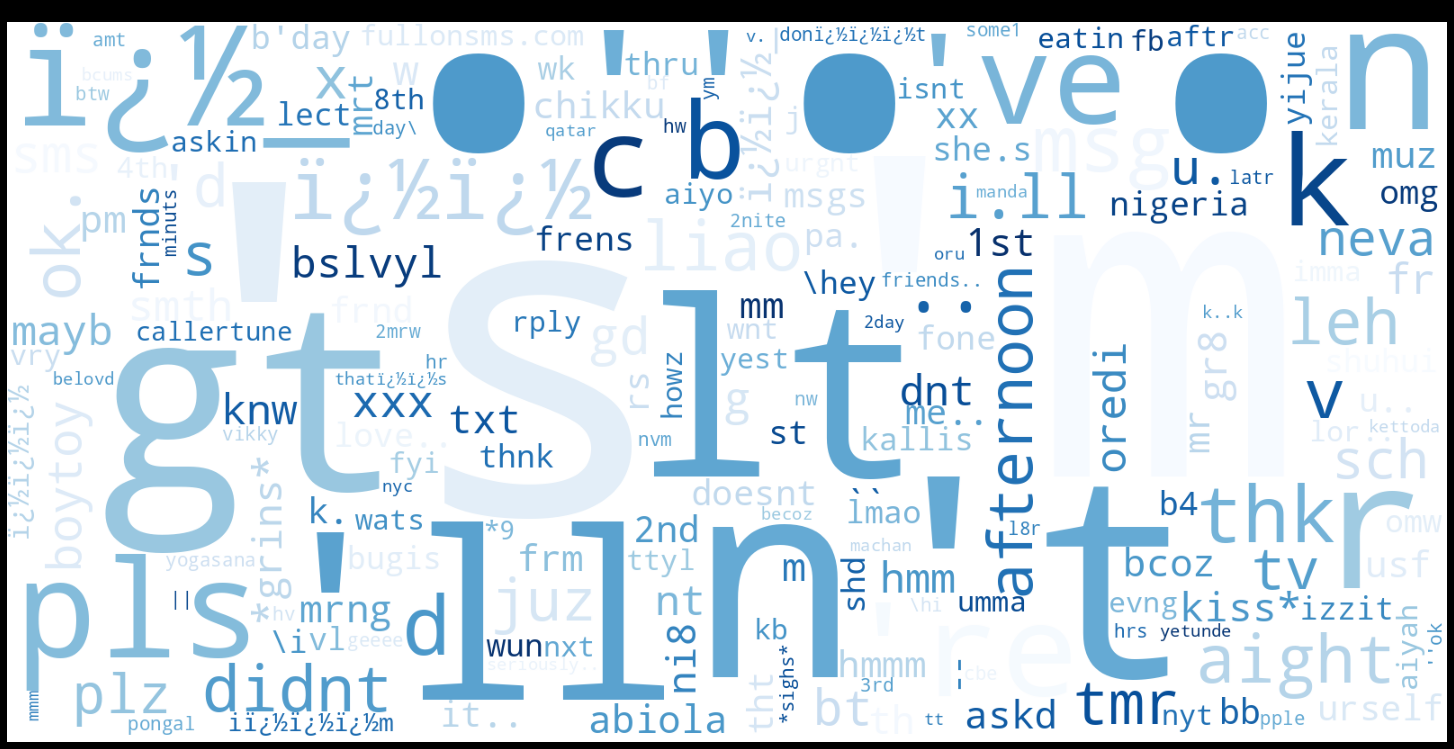

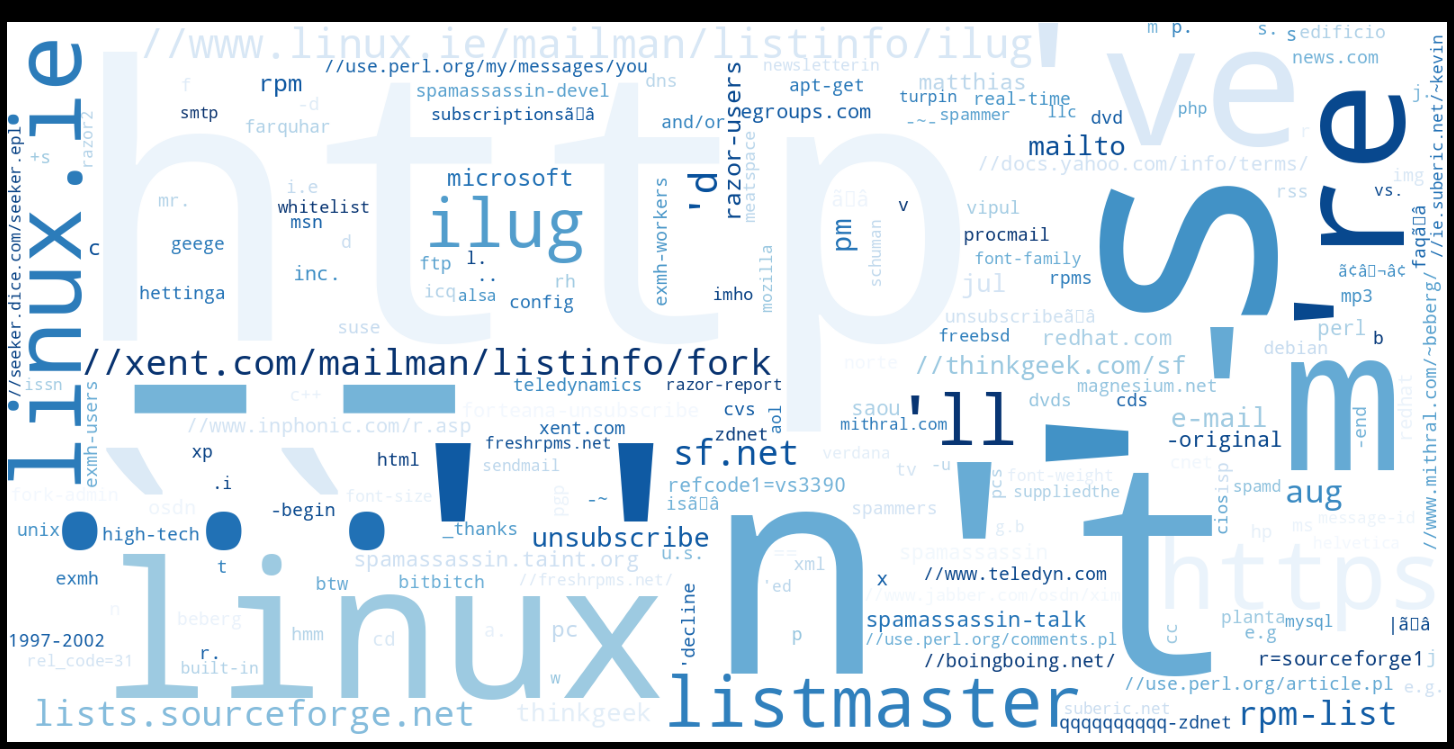

In [31]:
wordcloud = WordCloud(background_color="white", width=1600, height=800, colormap="Blues")

for ds in datasets[:2]:
    ham_cloud = wordcloud.generate_from_frequencies(frequencies=ham_freq_dist[ds])

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(ham_cloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title('Misspelled words (ham)')
    plt.savefig('misspell_ham_'+dfs[ds]['type']+'.png')
    plt.show()

# The supervised models

The following models:

- Jaccard KNN
- TF-IDF KNN
- TF-IDF NB

In [32]:
# resetting all parameters
%reset -f

## Initializing

In [33]:
import pandas as pd
import numpy as np
import math
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.frequent_patterns import apriori
from sklearn.model_selection import RepeatedKFold, KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score
import time
from mlxtend.preprocessing import TransactionEncoder

from ast import literal_eval
from tqdm import tqdm
import mmh3
from itertools import product
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import scipy.stats

seed = 42


### training function for TF-IDF models

In [34]:

#TDIDF
def identity_tokenizer(text):
    return text

def train(model, model_name, dataset, df_results, seed):
    # data
    #dataset = 'clean_completeSpamAssassin'
    #dataset = 'clean_spam'

    if dataset == 'clean_spam':
        new_dataset_name = 'SMS'
        min_df = 1
    else:
        new_dataset_name = 'Emails'
        min_df = 0.001
    # clean_completeSpamAssassin
    # clean_spam
    data = pd.read_csv(f'../data/clean/{dataset}.csv', encoding='latin')
    data.tokens = data.tokens.apply(literal_eval)

    df_text_tokenized = {i: [data['text'][i].split(' ')] for i in list(data.index)}
    data['text_tokenized'] = pd.DataFrame.from_dict(df_text_tokenized, orient='index')


    look_up_for_look_ups = ['raw/BOW', 'raw/Q', 'prep/BOW', 'prep/Q']
    look_ups = ['text_tokenized', 'text', 'tokens', 'str_tokens']
    dims = {}

    #print(f'Model: {model_name}')

    for idx, look_up in enumerate(look_ups):
        labels = ['ham', 'spam']
        q = 5
        num_neighs = 5 # 2
        num_folds = 5 # 5 fold
        dims[look_up] = []
        kf = RepeatedKFold(n_splits=num_folds, n_repeats=1, random_state=seed)
        f1_scores = []
        accuracies = []

        for train_idx, test_idx in tqdm(kf.split(data)):
            # sorting data
            df_train = data.loc[train_idx]
            df_test = data.loc[test_idx]
            # generating vectors
            if look_up in ['text', 'str_tokens']:
                # shingles
                corpus = list(data[look_up])
                vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(q, q), min_df=min_df).fit(corpus)
                #vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(q, q), max_df=0.7).fit(corpus)
                X = vectorizer.fit_transform(df_train[look_up])
                feature_names = vectorizer.get_feature_names_out()
                dims[look_up].append(len(feature_names))


            else:
                vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, min_df=min_df)
                #vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, max_df=0.7)
                vecs = vectorizer.fit_transform(df_train[look_up])
                feature_names = vectorizer.get_feature_names_out()
                dense = vecs.todense()
                lst1 = dense.tolist()
                TDM = pd.DataFrame(lst1, columns=feature_names).dropna()
                X = vecs
                dims[look_up].append(len(feature_names))
            # training classifier
            model.fit(X, df_train.label)
            # predicting
            test_vecs = vectorizer.transform(df_test[look_up])
            pred_prob = model.predict_proba(test_vecs)
            y_pred = [labels[pred_idx] for pred_idx in pred_prob.argmax(axis=1)]
            y_test = df_test.label
            # generating predictions
            f1 = f1_score(y_test, y_pred, pos_label='spam')
            acc = accuracy_score(y_test, y_pred)
            f1_scores.append(f1_score(y_test, y_pred, pos_label='spam'))
            accuracies.append(accuracy_score(y_test, y_pred))
        #print(look_up)
        #print(f'Dataset: {look_up_for_look_ups[idx]}')
        #print(f'f1_mean: {np.mean(f1_scores)}  |  f1: {f1_scores}')
        #print(f'acc_mean: {np.mean(accuracies)}  |  acc: {accuracies}')
        #print('\n')
        
        single_df_results = pd.DataFrame({'Model': [model_name]*num_results,
                                      'Dataset': [new_dataset_name]*num_results, 
                                      'Method': [look_up_for_look_ups[idx]]*num_results,
                                      'F1': f1_scores,
                                      'Accuracy': accuracies,
                                      })
        df_results = df_results.append(single_df_results)

        
    return df_results


### dataframe with results

In [35]:
# general dataframe with results
df_template = pd.DataFrame(columns=["Model", "Dataset", "Method", 'F1', 'Accuracy'])    # from low to high conf
df_results = df_template
num_results = 5

## Evaluating the KNN model

In [36]:
# defnining model
num_neighs = 5
model = KNeighborsClassifier(n_neighbors=num_neighs, metric='cosine')
model_name = 'TF-IDF KNN'

In [37]:
# running model on each dataset and for different data processing methods
datasets = ['clean_spam', 'clean_completeSpamAssassin']
for dataset in datasets:
    model_df_results = train(model, model_name, dataset, df_template, seed)
    df_results = df_results.append(model_df_results)

5it [01:08, 13.65s/it]
5it [00:06,  1.25s/it]
5it [00:26,  5.21s/it]
5it [00:03,  1.50it/s]
5it [01:35, 19.15s/it]
5it [01:26, 17.32s/it]
5it [00:36,  7.30s/it]
5it [00:35,  7.05s/it]


#### Saving the results

In [38]:
### Saving the results
df_results.to_csv('results.csv', index=False)

## Evaluating the NB model

In [39]:
df_results = pd.read_csv(f'results.csv')

In [40]:
# defnining model
# note the prior is 50/50, achieve better performance, i.e. f1 score
model = MultinomialNB(fit_prior=False)
model_name = 'TF-IDF NB'

In [41]:
# running model on each dataset and for different data processing methods
datasets = ['clean_spam', 'clean_completeSpamAssassin']
for dataset in datasets:
    model_df_results = train(model, model_name, dataset, df_template, seed)
    df_results = df_results.append(model_df_results)

5it [01:06, 13.27s/it]
5it [00:05,  1.06s/it]
5it [00:25,  5.18s/it]
5it [00:02,  1.75it/s]
5it [01:30, 18.07s/it]
5it [01:21, 16.24s/it]
5it [00:35,  7.18s/it]
5it [00:32,  6.46s/it]


#### Saving the results

In [42]:
### Saving the results
df_results.to_csv('results.csv', index=False)

## Evaluating the Jaccard KNN model

We start by defining the necessary functions to get document similarity (week 5 of course exercises). Please note that the listhash, minhash, and signatures are gone. We will not be using them in this model as we saw a decrease in model performance. We did not perform any extensive analysis and we believe this is due to the information loss as we minhash. And as we won't minhash there is no need to create hashes at all and therefore, there won't be any signatures. Just q-shingles!

### Defining functions

In [43]:
# create shingle function
def shingles(string:str,q:int):
    output = set()
    for i in range(len(string)+1):
        if i < q:
            pass
        else:
            output.add(''.join(string[i-q:i]))
    return output

#create jaccard sim function
def jaccard(doc1, doc2):
    intersect = np.intersect1d(doc1,doc2)
    union = np.union1d(doc1,doc2)
    if len(union) != 0:
        return len(intersect) / len(union)
    else:
        return 0
    
#create document sim function
def similarity(docs:dict):
    output = np.zeros((len(docs.keys()),len(docs.keys())))
    for key1, value1 in tqdm(docs.items()):
        for key2, value2 in docs.items():
            if key1 <= key2:
                pass
            else:
                jac_value = jaccard(np.array(value1),np.array(value2))
                output[key1,key2] = jac_value
    return np.tril(output) + np.triu(output.T, 1)


# the model
def weighted_knn(x, y_train,test_idx,low,high,k_neighbours=5):
    y_test = []
    mask = np.ones(len(x),bool)
    mask[y_test] = False
    for i in test_idx:
        ind = []
        temp = np.argpartition(x[i], -k_neighbours)[-k_neighbours:]
        temp = np.flip(temp)
        for idx in temp:
            if idx>=high or idx < low:
                ind.append(idx)
        topk = x[i][ind]
        labels = {j: y_train[j] for j in ind}
        ham = 0
        spam = 0
        for key, value in labels.items():
            if value == 0:
                ham += x[i][key]
            if value == 1:
                spam += x[i][key]
        
        if ham>spam:
            y_test.append(0)
        if ham == spam:
            y_test.append(0)
        if ham<spam:
            y_test.append(1)
        
    return y_test

Now we create the "training" loop. The training actually happens as we create the document similarity matrix. This function just evaluates one fold of a cross validation ind gives us the predicted labels for the test set in that fold.

Now we get to a piece of code that we are not really proud of. However, we decided to use no sklearn models in this section (except for evaluating f1-scores and accuracies). We evaluate the model with a $k$ (in KNN) of 5 and a $q$ of 5 as that was suggested by the course. We evaluate through a 5-fold cross validation and save all performance metrics from each run.

We also keep the predictions of the outer test set in order to do McNemar tests between models. This will be done in another notebook as this one has become quite extensive.

In [47]:
def jknn_train(model_name, dataset, df_results, seed):
    # data
    #dataset = 'clean_completeSpamAssassin'
    #dataset = 'clean_spam'

    if dataset == 'clean_spam':
        new_dataset_name = 'SMS'
        min_df = 1
    else:
        new_dataset_name = 'Emails'
        min_df = 0.001
    # clean_completeSpamAssassin
    # clean_spam
    data = pd.read_csv(f'../data/clean/{dataset}.csv', encoding='latin')
    data.tokens = data.tokens.apply(literal_eval)
    
    df_text_tokenized = {i: [data['text'][i].split(' ')] for i in list(data.index)}
    data['text_tokenized'] = pd.DataFrame.from_dict(df_text_tokenized, orient='index')


    look_up_for_look_ups = ['raw/BOW', 'raw/Q', 'prep/BOW', 'prep/Q']
    look_ups = ['text_tokenized', 'text', 'tokens', 'str_tokens']
    
    q=5
    
    for idx, look_up in enumerate(look_ups):
        print("Look_up",idx,"/",len(look_ups))
        # data is in strings
        if look_ups in ['text', 'str_tokens']:
            curr_data = {data.index[_]: shingles(data.iloc[:,1][_], q=q) for _ in data.index}
        # data is in tokens
        else:
            curr_data = data[look_up]
             
        sim_matrix = similarity(curr_data)
        kfold=5
        f1_scores = []
        accuracies = []
        test_set_percent = ((len(data)/kfold)/len(data))
        test_size = int(test_set_percent*len(data))
        former_test_idx = 0
        y_tests = []
        predicted = []
        for i in range(kfold):
            print("Fold:",i,"/",kfold)
            y_test = data['binary'][former_test_idx:(i+1)*test_size]
            y_tests = y_tests + list(y_test)
            y_idx = y_test.index
            mask = np.ones(len(data), bool)
            mask[y_idx] = False
            y_train = data['binary'][mask]
            y_pred = weighted_knn(sim_matrix,y_train,y_idx,former_test_idx,(i+1)*test_size,5)
            predicted = predicted + list(y_pred)
            f1_scores.append(f1_score(y_test,y_pred))
            accuracies.append(accuracy_score(y_test,y_pred))
            former_test_idx += test_size

        # saving look up, i.e. method
        single_df_results = pd.DataFrame({'Model': [model_name]*num_results,
                                  'Dataset': [new_dataset_name]*num_results, 
                                  'Method': [look_up_for_look_ups[idx]]*num_results,
                                  'F1': f1_scores,
                                  'Accuracy': accuracies,
                                  })
        df_results = df_results.append(single_df_results)

    return df_results
    
    
    

In [48]:
# loading results
df_results = pd.read_csv(f'results.csv')

## Evaluating the J KNN model

In [ ]:
model_name = 'J KNN'
# running model on each dataset and for different data processing methods
datasets = ['clean_spam', 'clean_completeSpamAssassin']
for dataset in datasets:
    print(dataset)
    model_df_results = jknn_train(model_name, dataset, df_template, seed)
    df_results = df_results.append(model_df_results)

clean_spam
Look_up 0 / 4


2784it [03:17,  7.44it/s]

### Saving the results

In [ ]:
### Saving the results
df_results.to_csv('results.csv', index=False)

## Analysing the results

With confidence level of 95%

In [ ]:
round = 3 # round numbers
data = pd.read_csv(f'results.csv')

In [ ]:

def mean_confidence_interval(data, round=3, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return np.round(m, round), np.round(m-h, round), np.round(m+h, round)


models = list(set(data.Model))
datasets = list(set(data.Dataset))
# force order
methods = ['raw/Q', 'prep/Q', 'raw/BOW', 'prep/BOW']

for model in models:
    print(model)
    for dataset in datasets:
        print(f'  {dataset}')
        for method in methods:
            current_data = data[(data.Model==model) & (data.Dataset==dataset) & (data.Method==method)]
            f1, f1_l, f1_h = mean_confidence_interval(list(current_data.F1), round=round)
            acc, acc_l, acc_h = mean_confidence_interval(list(current_data.Accuracy), round=round)
            # todo: round
            print(f'    {method}: f1: {f1}, [{f1_l},{f1_h}] | acc: {acc}, [{acc_l},{acc_h}]')
    print('\n')


## resetting

In [ ]:
# resetting all parameters
%reset -f

# Unsupervised Clustering
The following part of the notebook will contain the code used to investigate the potential value of a clustering approach for spam detection.

In [ ]:
%reset -f

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import nltk
from sklearn.cluster import DBSCAN
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import scipy.spatial.distance
from scipy.special import softmax
from scipy.spatial.distance import cdist
from sklearn import metrics
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm.notebook import tqdm

In [ ]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    return None
setup_mpl()

## Implementation of K-means & K-means ++

The following two code cells contain the K-means implementation and the centroid initialization scheme, which is K-means ++. The specific approach of the initalization is described in the docstring of the plus-plus function.

In [ ]:
def plus_plus(X, k, random_state=42, verbose=True):
    '''
    ##########################
    #k-means++ initialization#
    ##########################
    
    The approach:
         * 1st centroid is chosen uniformly at random from the observations.
         * Subsequently, the remaining centroids are chosen from the remaining observation with probability
           proportionally with the squared distance to the closest existing centroid
    
    Parameters:
        * X : Observations, X \in R^{observations x features}
        * k : Number of centroids
        * random_state : seed
    
    by Christian Djurhuus
    '''
    np.random.seed(random_state)
    
    # Allocating memory
    centroids = np.zeros((k, X.shape[1]))
    
    # Sampling first centroid uniformly at random from observations
    indicies = [i for i in range(X.shape[0])]
    first_idx = np.random.choice(indicies, size=1)
    indicies.remove(first_idx)
    centroids[0,:] = X[first_idx, :]

    # Determining remaining number of centroids:
    for i in range(1,k):
        if verbose:
            print(f'Number of centroids defined: {i+1}')
        # Compute distance between all observations and existing centroids
        pair_dist = (((np.expand_dims(X[indicies,:], 1)-centroids[:i,:]+1e-06)**2).sum(-1))
        #pair_dist = cdist(X[indicies,:], centroids[:i,:], metric='euclidean')

        # Probabilities:
        if pair_dist.ndim==1:
            #only one centroid available. Hence, dist to nearest centroid is just pair dist
            dist = pair_dist
            #probs = (np.exp(dist) / np.sum(np.exp(dist), axis=0))
            probs = dist/dist.sum()
        else:
            dist = pair_dist.min(axis=1)
            #probs = (np.exp(dist) / np.sum(np.exp(dist), axis=0))
            probs = dist/dist.sum()


        #Selecting one of the remaining observations
        selected_idx = np.random.choice(indicies,size=1, p=probs)
        indicies.remove(selected_idx)
        centroids[i, :] = X[selected_idx, :]
    
    return centroids

In [ ]:
def kmeans(X, k, random_state=42, tot=1e-4, n_init=10, verbose=True):
    '''
    ##########################
    #k-means#
    ##########################
    
    Function run n_init number of k-means clustering and return the result with smallest inertia.
    The implementation have utilized numpy's broadcasting functionalities to increase 
    computational speed w.r.t computing pairwise distances.
    
    Parameters:
        * X : Observations, X \in R^{observations x features}
        * k : Number of centroids
        * random_state : seed
        * tot : tolerance criteria for loose convergence criteria
        * n_init : number of K-means run 
    
    by Christian Djurhuus
    '''
    #Substracting mean of data
    X -= X.mean(axis=0)

    best_inertia = 1e6

    #run n_init number of the kmeans algorithm and return clusters with minimum inertia
    for i in range(1, n_init+1):
        if verbose:
            print(f'Kmeans run no. {i}')
        
        #Determining centroids using kmeans++
        centroids = plus_plus(X=X, k=k, random_state=i*random_state, verbose=verbose)

        #initial placeholder
        prev_centroids = np.zeros(centroids.shape)
        assignments = np.zeros(X.shape[0])

        #Run until convergence
        itr = 1
        diff = 1e5
        while not np.allclose(prev_centroids, centroids):
            if verbose:
                print(f'Iteration number: {itr} - diff {diff}')
            prev_diff = diff
            prev_assignments = assignments

            #Using broadcasting to compute pairwise distances between observations and centroids
            dists=((np.expand_dims(X, 1)-centroids+1e-06)**2).sum(-1)**0.5
            assignments = dists.argmin(axis=1)
            prev_centroids = centroids.copy()

            #Update centroid position
            for idx in range(k):
                centroids[idx, :] = X[np.where(assignments==idx)].mean(axis=0)

            itr += 1


            #Distance between previous centroids and current
            diff = ((((prev_centroids - centroids + 1e-6)**2).sum(-1))**0.5).sum()

            #Early stopping when converged
            if np.array_equal(prev_assignments, assignments): #Check for strict convergence
                break

            if diff < tot: #Check for loose convergence
                break

        #Computing inertia
        #Sum of squared distance between each sample and its assigned center.
        inertia = 0
        for idx in range(k):

            inertia += np.sum((np.expand_dims(X[np.where(assignments==idx)],1) - centroids[idx, :]) ** 2, axis=0).sum() #squared dist

        if inertia < best_inertia:
            best_inertia = inertia
            if verbose:
                print(f'Current best inertia: {best_inertia}')
            best_assignments = assignments
            best_centroids = centroids

    return best_assignments, best_centroids, best_inertia

The following function defines the performance metrics utilized within this project:

In [ ]:
def performance_metrics(X, assign, labels):
    ARI = metrics.adjusted_rand_score(labels, assign)
    NMI = metrics.adjusted_mutual_info_score(labels, assign)
    DBI = metrics.davies_bouldin_score(X, assign)
    
    print(f'ARI: {ARI:.3f}')
    print(f'NMI: {NMI:.3f}')
    print(f'DBI: {DBI:.3f}')
    print('\n')
    return ARI, NMI, DBI

## SMS

Reading the cleaned sms data:

In [ ]:
df = pd.read_csv('../data/clean/clean_spam.csv')
df['tokens'] = df['tokens'].apply(literal_eval)
df.head()

Vectorizing the documents using TFIDF. To be able to use our own tokenized data as input, an identity tokenizer is defined in given to the sklean TFIDF implementations. This prohibit sklearn from conducting any extra preprocessing, such that we only use our own preprocessing procedure.

In [ ]:
#TDIDF
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False
                            )

vecs = vectorizer.fit_transform(df['tokens'])
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
TDM = pd.DataFrame(lst1, columns=feature_names).dropna()
X = vecs

### Clustering in Original Space

#### Hyperparameter tuning

First we will choose the most suitable $K$ in K-means by using the obtained inertia with varying values of $K$. The iniertia describes the sum of squared distance between each sample and its assigned centroid. Hence, a low inertia will indicate more well-defined clusters w.r.t inner distance:

In [ ]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in tqdm(enumerate(np.arange(2,10,1))):
    assign, centroids, inertia = kmeans(X, k=k, random_state=2, tot=1e-4, verbose=False)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

Usually, we would choose the value of $K$ associated with the highest curvature. However, given that curve resembles a straight line and only marginal gains appear with increasing $K$, we decide to use $K=2$.

Subsequently, we will choose the most suitable $\epsilon$ value used in DBSCAN by visualising the distance between the n nearest neighbours as a function of n. $\epsilon$ is choosed where the curve express the highest curvature:

In [ ]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 10
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,n_neighbors-1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("n")
plt.ylabel("Distance")
plt.show()

This approach appeared to be a bit more challenging than selecting $K$, we see that the highest curvature is with a very small epsilon value. Different epsilon values was also tried and the best appeared to be $\epsilon=0.1$, this is also true for all the other experiments. 

#### Performing Clustering

Conducting the clustering using the hyperparameters identified above:

In [ ]:
from sklearn.cluster import DBSCAN
kmeans_assign, centroids, _ = kmeans(X, k=2, random_state=2, tot=1e-4, verbose=False)
clustering_db = DBSCAN(eps=0.1, min_samples=2).fit(X)
dbscan_assign = clustering_db.labels_

Evaluating performance:

In [ ]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(X.toarray(), kmeans_assign, labels)
performance_metrics(X.toarray(), dbscan_assign, labels)

### Latent Semantic Analysis


Computing the truncated SVD that approximately explains 50% of the variance.

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
X_svd = svd.fit_transform(X)
var_explained = svd.explained_variance_ratio_.sum()
print(var_explained)

#### Hyperparameter tuning

Selecting $K$:

In [ ]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(X_svd, k=k, random_state=2, tot=1e-4, verbose=False)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

Selecting $\epsilon$:

In [ ]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 10
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors = nearest_neighbors.fit(X_svd)
distances, indices = neighbors.kneighbors(X_svd)
distances = np.sort(distances[:,n_neighbors-1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("n")
plt.ylabel("Distance")
plt.show()

#### Performing Clustering
Conducting clustering:

In [ ]:
clustering_db = DBSCAN(eps=0.1, min_samples=2).fit(X_svd)
dbscan_assign = clustering_db.labels_
kmeans_assign, centroids, _ = kmeans(X_svd, k=2, random_state=2, tot=1e-4, n_init=10, verbose=False)

Evaluating performance

In [ ]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(X_svd, kmeans_assign, labels)
performance_metrics(X_svd, dbscan_assign, labels)

### Cosine Distance

In [ ]:
from sklearn.metrics import pairwise_distances
dist = pairwise_distances(X, metric='cosine')

#### Hyperparameter tuning
Selecting $K$:

In [ ]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in tqdm(enumerate(np.arange(2,10,1))):
    assign, centroids, inertia = kmeans(dist, k=k, random_state=2, tot=1e-4, verbose=False)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

Selecting $\epsilon$:

In [ ]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=100)
neighbors = nearest_neighbors.fit(dist)
distances, indices = neighbors.kneighbors(dist)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("n")
plt.ylabel("Distance")
#plt.xlim([0, 500])
plt.savefig("Distance_curve.png", dpi=300)

#### Performing Clustering
Conducting clustering:

In [ ]:
kmeans_assign, centroids_kmeans, _ = kmeans(dist, k=2, random_state=2, tot=0.0001, n_init=10, verbose=False)
dist = pairwise_distances(X, metric='cosine')
clustering_db = DBSCAN(eps=0.1, min_samples=2, metric='precomputed').fit(dist)
dbscan_assign = clustering_db.labels_

Evaluating performance:

In [ ]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(dist, kmeans_assign, labels)
performance_metrics(dist, dbscan_assign, labels)

### Spectral Clustering 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(X)

In [ ]:
# Define affinity matrix
A = similarity

#Setting diagonal elements to 0.0 and removing documents with no similarity with other documents
np.fill_diagonal(A, 0.0)
row_sum = A.sum(0)
removed_idx = np.where(A.sum(0)==0)[0]
A_reduced = A[row_sum != 0, :]
A_reduced = A_reduced[:, row_sum!=0]

assert np.where(A_reduced.sum(0)==0)[0].size == 0
assert np.where(A_reduced.sum(1)==0)[0].size == 0

# Define D as a diagonal matrix where element (i,i) corresponds to the sum of ith row in A
D = np.diag(A_reduced.sum(axis=0))
D_pow = np.diag(np.power(np.diagonal(D), -0.5))
# Define L=D^{-1/2}AD^{-1/2}
L = D_pow@A_reduced@D_pow

# Find the k largest eigenvectors of L
eigenvals, eigenvectors = np.linalg.eigh(L)

k = 10
k_largest = np.argpartition(eigenvals, -k)[-k:]

#Create matrix X_spec = [x1,...,xk]
X_spec = eigenvectors[:, k_largest]

# Define Y as X row normalized
Y = X_spec/np.linalg.norm(X_spec, axis=0)

row_sums = np.power(X_spec, 2).sum(axis=1)
#row_sums = X_spec.sum(axis=1)
Y = (X_spec / np.power(row_sums[:, np.newaxis], 0.5))
#Y = X_spec / row_sums[:, np.newaxis]
Y = np.nan_to_num(Y)

#### Hyperparameter tuning
Choosing $K$:

In [ ]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(Y, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias, c='darkblue')
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

#### Conducting clustering

In [ ]:
kmeans_spec_assign, centroids, _ = kmeans(Y, k=2, random_state=2, tot=1e-4, verbose=False)

Evaluating performance:

In [ ]:
labels = df.drop(removed_idx).label.replace({'ham':0, 'spam':1}).values
performance_metrics(Y, kmeans_spec_assign, labels)

## Emails
This section will conduct the exact same procedure as the above. Hence, the number of comments will be limited and for further explainations please see the section above.

In [ ]:
df = pd.read_csv('data/clean/clean_completeSpamAssassin.csv')
df['tokens'] = df['tokens'].apply(literal_eval)
df.head()

In [ ]:
#TDIDF
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,
                             lowercase=False
                            )

vecs = vectorizer.fit_transform(df['tokens'])
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
TDM = pd.DataFrame(lst1, columns=feature_names).dropna()
X = vecs

### Clustering in Original Space
Choosing $K$:

In [ ]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in tqdm(enumerate(np.arange(2,10,1))):
    assign, centroids, inertia = kmeans(X, k=k, random_state=2, tot=1e-4, verbose=False)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

Choosing $\epsilon$:

In [ ]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 10
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,n_neighbors-1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("n")
plt.ylabel("Distance")
plt.show()

#### Performing Clustering
Conducting clustering

In [ ]:
kmeans_assign, centroids, _ = kmeans(X, k=2, random_state=2, tot=1e-4, verbose=False)
clustering_db = DBSCAN(eps=0.1, min_samples=2).fit(X)
dbscan_assign = clustering_db.labels_

Evaluating performance:

In [ ]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(X.toarray(), kmeans_assign, labels)
performance_metrics(X.toarray(), dbscan_assign, labels)

### Latent Semantic Analysis

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=)
X_svd = svd.fit_transform(X)
var_explained = svd.explained_variance_ratio_.sum()
print(var_explained)

#### Hyperparameter tuning
Choosing $k$:

In [ ]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(X_svd, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

Choosing $\epsilon$:

In [ ]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=100)
neighbors = nearest_neighbors.fit(X_svd)
distances, indices = neighbors.kneighbors(X_svd)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("n")
plt.ylabel("Distance")
plt.savefig("Distance_curve.png", dpi=300)

### Performing clustering
Conducting clustering:

In [ ]:
kmeans_assign, centroids, _ = kmeans(X_svd, k=4, random_state=2, tot=1e-4, verbose=False)

clustering_db = DBSCAN(eps=0.1, min_samples=2).fit(X_svd)
dbscan_assign = clustering_db.labels_

Evaluating performance:

In [ ]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(X_svd, kmeans_assign, labels)
performance_metrics(X_svd, dbscan_assign, labels)

### Cosine Distance

In [ ]:
dist = pairwise_distances(X, metric='cosine')

#### Hyperparameter tuning
Choosing $K$:

In [ ]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(dist, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

Choosing $\epsilon$:

In [ ]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=100)
neighbors = nearest_neighbors.fit(dist)
distances, indices = neighbors.kneighbors(dist)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
#plt.xlim([0, 500])
plt.savefig("Distance_curve.png", dpi=300)

#### Performing Clustering

Conducting clustering:

In [ ]:
kmeans_assign, centroids_kmeans, _ = kmeans(dist, k=4, random_state=2, tot=0.0001, n_init=10)

In [ ]:
dist = pairwise_distances(X, metric='cosine')
clustering_db = DBSCAN(eps=0.1, min_samples=2, metric='precomputed').fit(dist)
dbscan_assign = clustering_db.labels_

Evaluating performance:

In [ ]:
labels = df.label.replace({'ham':0, 'spam':1}).values
performance_metrics(dist, kmeans_assign, labels)
performance_metrics(dist, dbscan_assign, labels)

### Spectral Clustering

In [ ]:
similarity = cosine_similarity(X)

In [ ]:
# Define affinity matrix
A = similarity

#Setting diagonal elements to 0.0 and removing documents with no similarity with other documents
np.fill_diagonal(A, 0.0)
row_sum = A.sum(0)
removed_idx = np.where(A.sum(0)==0)[0]
A_reduced = A[row_sum != 0, :]
A_reduced = A_reduced[:, row_sum!=0]

assert np.where(A_reduced.sum(0)==0)[0].size == 0
assert np.where(A_reduced.sum(1)==0)[0].size == 0

# Define D as a diagonal matrix where element (i,i) corresponds to the sum of ith row in A
D = np.diag(A_reduced.sum(axis=0))
D_pow = np.diag(np.power(np.diagonal(D), -0.5))
# Define L=D^{-1/2}AD^{-1/2}
L = D_pow@A_reduced@D_pow

# Find the k largest eigenvectors of L
eigenvals, eigenvectors = np.linalg.eigh(L)

k = 10
k_largest = np.argpartition(eigenvals, -k)[-k:]

#Create matrix X_spec = [x1,...,xk]
X_spec = eigenvectors[:, k_largest]

# Define Y as X row normalized
Y = X_spec/np.linalg.norm(X_spec, axis=0)

row_sums = np.power(X_spec, 2).sum(axis=1)
#row_sums = X_spec.sum(axis=1)
Y = (X_spec / np.power(row_sums[:, np.newaxis], 0.5))
#Y = X_spec / row_sums[:, np.newaxis]
Y = np.nan_to_num(Y)

#### Hyperparameter tuning
Choosing $K$:

In [ ]:
inertias = np.zeros(8)
best_inertia = 1e5
for i, k in enumerate(np.arange(2,10,1)):
    assign, centroids, inertia = kmeans(Y, k=k, random_state=2, tot=1e-4)
    inertias[i] = inertia
    if inertia < best_inertia:
        best_assign = assign
        best_centroids = centroids
        best_inertia = inertia

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.arange(2,10,1), inertias, c='darkblue')
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
plt.show()

#### Performing Clustering
Conducting clustering:

In [ ]:
kmeans_spec_assign, centroids, _ = kmeans(Y, k=3, random_state=2, tot=1e-4, verbose=False)

Evaluating performance:

In [ ]:
labels = df.drop(removed_idx).label.replace({'ham':0, 'spam':1}).values
performance_metrics(Y, kmeans_spec_assign, labels)

## Visualizing Clustering Results
The following section will visualize the best obtained clustering results (Spectral clustering with K-means) wil be visualised and analysed in more depth.

### Reorganized Affinity Matrix

The following is the reorganized pairwise cosine similarity matrix both using the ground truth partition and the cluster allocations:

In [ ]:
new_order = labels.argsort()

_, group_len = np.unique(labels, return_counts=True)


D = A_reduced[:, new_order][new_order]

fig, (ax1) = plt.subplots(figsize=(10,10), dpi=100)
ax1.spy(D, precision=0.5, markersize=0.5)
ax1.set_xticks([])
ax1.set_yticks([])

y = labels
N = A_reduced.shape[0]
counts=np.unique(y,return_counts=True)[1]
counts_j=np.unique(y,return_counts=True)[1]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, color='k', alpha=0.8)
    ax1.add_line(line)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, color='k', alpha=0.8)
    ax1.add_line(line)

fig.savefig('sim_matrix_ground_truth.png', dpi=100)

fig, (ax2) = plt.subplots(figsize=(10,10), dpi=100)

freq = np.flip(np.argsort(np.bincount(kmeans_spec_assign))[-(np.unique(kmeans_spec_assign).size):])
new_order = np.hstack((np.where(kmeans_spec_assign==freq[0])[0], 
                       np.where(kmeans_spec_assign==freq[1])[0],
                       np.where(kmeans_spec_assign==freq[2])[0]))

D = A[:, new_order][new_order]

ax2.spy(D, precision=0.5, markersize=0.5)
ax2.set_xticks([])
ax2.set_yticks([])

y = kmeans_spec_assign
N = len(y)
counts=np.unique(y,return_counts=True)[1][freq]
counts_j=np.unique(y, return_counts=True)[1][freq]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, color='k', alpha=0.8)
    ax2.add_line(line)

for i in range(cum_j.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, color='k', alpha=0.8)
    ax2.add_line(line)
    
plt.show()

### PCA

In [ ]:
from sklearn import decomposition

The following figures visualize the PCA of the Emails dataset annotated by the ground truth class and the cluster allocations:

In [ ]:
X_reduced = np.delete(X.toarray(), removed_idx, axis=0)
pca = decomposition.PCA(n_components=2)
pca.fit(X_reduced)
pca_emb = pca.transform(X_reduced)

In [ ]:
ham_idx = np.where(labels==0)[0]
spam_idx = np.where(labels==1)[0]


fig, ax1 = plt.subplots(figsize=(10,10), dpi=100)
clust1 = np.where(kmeans_spec_assign==0)[0]
clust2 = np.where(kmeans_spec_assign==1)[0]
clust3 = np.where(kmeans_spec_assign==2)[0]

ax1.scatter(pca_emb[:,0][ham_idx], 
            pca_emb[:,1][ham_idx],
            c='lightblue',
            s=5,
            label='ham')
ax1.scatter(pca_emb[:,0][spam_idx], 
            pca_emb[:,1][spam_idx],
            c='lightcoral',
            s=5,
            label='spam')

ax1.set_xlabel('PC1', fontsize=18)
ax1.set_ylabel('PC2', fontsize=18)
#ax1.set_title('Ground truth')

ax1.legend(prop={'size': 20})
fig.savefig('pca_embedding_ground_truth.png', dpi=100)

fig, ax2 = plt.subplots(figsize=(10,10), dpi=100)

ax2.scatter(pca_emb[:,0][clust2], 
            pca_emb[:,1][clust2],
            c='lightblue',
            s=5,
            label='cluster 1')
ax2.scatter(pca_emb[:,0][clust1], 
            pca_emb[:,1][clust1],
            c='lightcoral',
            s=5,
            label='cluster 2')
ax2.scatter(pca_emb[:,0][clust3], 
            pca_emb[:,1][clust3],
            c='khaki',
            s=5,
            label='cluster 3')

ax2.set_xlabel('PC1', fontsize=18)
ax2.set_ylabel('PC2', fontsize=18)
#ax2.set_title('Community assignment')
legend = ax2.legend(prop={'size': 20})
fig.savefig('pca_embedding_community.png', dpi=100)
plt.show()

## Missclassifications
By inspecting the visualisations of the clusters both in the PCA figures and the reordered pairwise similarity/affinity matrix, it seems as if the spectral clustering algorithmm have identified three clusters. One of which is mainly composed of ham mails, while the other two appear to be composed of spam mails. As a first step let us validate these indications:

In [ ]:
clust1_dist = np.unique(labels[np.where(kmeans_spec_assign==0)[0]], return_counts=True)
clust2_dist = np.unique(labels[np.where(kmeans_spec_assign==1)[0]], return_counts=True)
clust3_dist = np.unique(labels[np.where(kmeans_spec_assign==2)[0]], return_counts=True)

In [ ]:
for dist in [clust1_dist, clust2_dist, clust3_dist]:
    fig, ax = plt.subplots(figsize=(5,5), dpi=100)
    bar = ax.bar(['ham', 'spam'], dist[1], color=['lightblue', 'lightcoral'])
    
    # Add counts above the two bar graphs
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height/(np.sum(dist[1])):.3f}%', ha='center', va='bottom')

    plt.show()

The above illustrations verify the earlier indications.

As the next step in our analysis we will take a deeper look into where the classifications go wrong, and try to deduce why the misclassification might occur. First we will look into the non identified spam mails, that have been assigned to cluster with a majority of ham mails.

In [ ]:
from wordcloud import WordCloud
idx = np.where(kmeans_spec_assign==1)[0]
clust2 = labels[idx]

feature_names = vectorizer.get_feature_names_out()
TDM = pd.DataFrame(X_reduced, columns=feature_names).dropna()
miss_classified = TDM.iloc[idx[np.where(clust2==1)[0]], :]

clust_cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(miss_classified.T.sum(axis=1))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.imshow(clust_cloud)
ax.axis("off")
ax.set_title('TFIDF weighted words \n Missclassified SPAM')
#plt.savefig('wordcloud_miss_spam.png',dpi=100)
plt.show()

It definitely stands out as SPAM. We will try to go through a few examples:

In [ ]:
miss_classified_text = df.drop(removed_idx).iloc[idx[np.where(clust2==1)[0]],:].text.values

In [ ]:
miss_classified_text[0]

In [ ]:
miss_classified_text[2]

In [ ]:
miss_classified_text[30]

A possible explanation of the algorithm's shortcoming can be our approach to handle URL links, given that the wordcloud of the TFIDF weighted words highlights the importance of words such as URL or link among the missclasified spam mails. Let us try to investigate the amount of URLs:

In [ ]:
import re
tot_urls = 0
for text in miss_classified_text:
    tot_urls += len(re.findall(r'(https?://[^\s]+)', text))

In [ ]:
print(f'The average number of URLs: {tot_urls/len(miss_classified_text):.2f}')

Let us compare this number to the spam mails of the two other clusters:

In [ ]:
clust1 = labels[np.where(kmeans_spec_assign == 0)[0]]
clust3 = labels[np.where(kmeans_spec_assign == 2)[0]]

for clust in [clust1, clust3]:
    temp_text = df.drop(removed_idx).iloc[idx[np.where(clust==1)[0]],:].text.values

    tot_urls = 0
    for text in temp_text:
        tot_urls += len(re.findall(r'(https?://[^\s]+)', text))
    print(f'The average number of URLs: {tot_urls/len(temp_text):.2f}')

Interestingly, one can see that there on average is more links/URLs in the missclassified spam than in the correctly identified spam. Hence, a possible explanation could in fact be that this shortcoming arises due to our initial manipulation of URLs.

A second thing we can look into is the ham mails being classified as spam:

In [ ]:
miss_classified_c1 = TDM.iloc[idx[np.where(clust1==0)[0]], :]
miss_classified_c2 = TDM.iloc[idx[np.where(clust3==0)[0]], :]

clust1_cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(miss_classified_c1.T.sum(axis=1))
clust2_cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(miss_classified_c2.T.sum(axis=1))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.imshow(clust1_cloud)
ax.axis("off")
plt.savefig('wordcloud_miss_hamm_c1.png', dpi=100)
#ax.set_title('TFIDF weighted words \n Missclassified HAM (cluster 1)')
plt.show()

fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.imshow(clust2_cloud)
ax.axis("off")
#ax.set_title('TFIDF weighted words \n Missclassified HAM (cluster 3)')
#fig.tight_layout()
plt.savefig('wordcloud_miss_hamm_c2.png', dpi=100)
plt.show()

## Wordclouds for each cluster

In [ ]:
clust1_idx = np.where(kmeans_spec_assign==0)[0]
clust2_idx = np.where(kmeans_spec_assign==1)[0]
clust3_idx = np.where(kmeans_spec_assign==2)[0]

In [ ]:
for i, clust in enumerate([clust1_idx, clust2_idx, clust3_idx]):
    miss_classified = TDM.iloc[clust,:]
    clust_cloud = WordCloud(background_color="white", width=1600, height=800).generate_from_frequencies(miss_classified.T.sum(axis=1))
    
    fig, ax = plt.subplots(figsize=(10,10), dpi=100)
    ax.imshow(clust_cloud)
    ax.axis("off")
    #ax.set_title(f'TFIDF weighted words: cluster {i}')
    plt.savefig(f'wordcloud_cluster_{i+1}.png',dpi=100)
    plt.show()